In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error,root_mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

from sklearn.linear_model import LogisticRegression, Ridge,LinearRegression
from xgboost import XGBRegressor
from datetime import datetime



# 一、特征工程


In [2]:
def get_mode_or_nan(series):
    mode = series.mode()
    if not mode.empty:
        return mode[0] # 如果有多个众数，默认取第一个
    else:
        return np.nan # 如果该组内全是 NaN (没有众数)，则返回 NaN

In [3]:
details=pd.read_csv("ruc_Class25Q1_details.csv")
rent=pd.read_csv("ruc_Class25Q1_rent.csv")
test=pd.read_csv("ruc_Class25Q1_test.csv")
train=pd.read_csv("ruc_Class25Q1_train.csv")

In [4]:
# 删除缺失值过多的列：抵押信息、套内面积、户型介绍、周边配套、交通出行、核心卖点 

train = train.drop(columns=['抵押信息','户型介绍','交通出行','周边配套','核心卖点'])
test = test.drop(columns=['抵押信息','户型介绍','交通出行','周边配套','核心卖点'])

In [5]:
# 删除缺失值过多的列:物业办公电话、供暖、停车费用
# 删除重复的列：coord_x, coord_y，建筑年代，小区地址、物业类别、产权描述

details = details.drop(columns=[ '物业办公电话','环线位置','建筑结构','建筑年代','小区地址','停车费用','物业类别','产权描述','coord_x','coord_y','供暖'])


In [6]:
details=details.rename(columns={'名称':'小区名称','区县':'区域'})

In [7]:
train_dt=pd.merge(train,details,on=['小区名称','区域','城市'],how='left')
test_dt=pd.merge(test,details,on=['小区名称','区域','城市'],how='left')

In [8]:
full=pd.concat([train_dt, test_dt], ignore_index=True)

# 环线位置

In [9]:
# 填补环线数据，寻找最佳参数

def find_optimal_k_for_imputation(df_source, cities_to_evaluate, k_range,
                                  feature_cols, target_col_encoded, random_state=42):
    """
    通过在指定城市的数据上制造人工缺失值来评估不同K值的插补准确率。

    参数:
    - df_source: 包含特征和已编码目标列的DataFrame。
    - cities_to_evaluate: 用于评估K值的城市列表。
    - k_range: 要测试的K值列表 (例如 [1, 3, 5, 7, 9])。
    - feature_cols: 用于插补的特征列名列表 (例如 ['区域', 'lon', 'lat'])。
    - target_col_encoded: 已标签编码的目标列名 (例如 '环线位置_encoded')。
    - random_state: 随机种子，用于可复现的划分。

    返回:
    - best_k: 表现最好的K值。
    - k_accuracies_avg: 每个K值对应的平均准确率字典。
    """

    k_accuracies_all_cities = {k: [] for k in k_range} # 存储每个K在各个城市的准确率
    for city_val in cities_to_evaluate:
        city_df_known_ring = df_source[
            (df_source['城市'] == city_val) & (df_source[target_col_encoded].notna())
        ].copy()

        if len(city_df_known_ring) < 20: # 数据太少，不适合划分和评估 (阈值可调整)
            print(f"城市 '{city_val}' 的已知数据量 ({len(city_df_known_ring)}) 过少，跳过K值评估。")
            continue

        print(f"评估城市 '{city_val}' (已知数据: {len(city_df_known_ring)})...")
        X_known = city_df_known_ring[feature_cols]
        y_known = city_df_known_ring[target_col_encoded]

        try:
            X_train_val, X_test_val, y_train_val, y_test_val_ground_truth = train_test_split(
                X_known, y_known, test_size=0.25, random_state=random_state, stratify=y_known
            )
        except ValueError: # 如果分层失败 (通常因为类别样本数不足)
            X_train_val, X_test_val, y_train_val, y_test_val_ground_truth = train_test_split(
                X_known, y_known, test_size=0.25, random_state=random_state
            )
        
        if X_train_val.empty or X_test_val.empty:
            print(f"城市 '{city_val}' 划分后的训练集或测试集为空，跳过。")
            continue

        # 特征预处理器 (在当前城市的X_train_val上fit)
        current_preprocessor_for_eval = ColumnTransformer(
            transformers=[
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['区域']),
                ('scaler', StandardScaler(), ['lon', 'lat'])
            ],
            remainder='passthrough'
        )

        X_train_val_processed = current_preprocessor_for_eval.fit_transform(X_train_val)
        X_test_val_processed = current_preprocessor_for_eval.transform(X_test_val)

        for k_val in k_range:
            if k_val > len(X_train_val_processed): # K不能大于训练样本数
                continue
            
            knn_eval = KNeighborsClassifier(n_neighbors=k_val)
            knn_eval.fit(X_train_val_processed, y_train_val)
            y_pred_eval = knn_eval.predict(X_test_val_processed)
            
            acc = accuracy_score(y_test_val_ground_truth, y_pred_eval)
            k_accuracies_all_cities[k_val].append(acc)
            # print(f"  K={k_val}, 准确率: {acc:.4f}")

    # 计算每个K的平均准确率
    k_accuracies_avg = {
        k: np.mean(acc_list) if acc_list else 0
        for k, acc_list in k_accuracies_all_cities.items()
    }
    
    print("\n各K值平均准确率:")
    for k, avg_acc in k_accuracies_avg.items():
        print(f"  K={k}: {avg_acc:.4f} (基于 {len(k_accuracies_all_cities[k])} 个城市的评估)")

    if not any(k_accuracies_avg.values()): # 如果所有准确率都是0 (例如没有城市被评估)
        print("警告：未能有效评估K值，将使用默认K=5。")
        return 5, k_accuracies_avg
        
    best_k = max(k_accuracies_avg, key=k_accuracies_avg.get)
    print(f"--- 最优K值确定为: {best_k} (平均准确率: {k_accuracies_avg[best_k]:.4f}) ---\n")
    return best_k, k_accuracies_avg

In [10]:
# 拟合目标编码函数

def fit_grouped_target_encoder(df, city_col, ring_col, target_col, smoothing_weight):
    """
    计算分组目标编码所需的映射关系。

    返回:
    - encodings_map: 字典 {city: {ring: smoothed_value}}
    - city_means_map: 字典 {city: city_overall_mean_target}
    - global_mean: float, 数据集全局目标均值
    """
    print(f"\n--- 正在从提供的数据集计算目标编码映射 (基于 '{target_col}') ---")
    global_mean = df[target_col].mean()
    
    encodings_map = {} 
    city_means_map = {}

    for city_name, city_group in df.groupby(city_col):
        city_overall_mean = city_group[target_col].mean()
        city_means_map[city_name] = city_overall_mean
        
        current_city_ring_encodings = {}
        for ring_name, ring_group in city_group.groupby(ring_col):
            count = len(ring_group)
            group_mean_target = ring_group[target_col].mean()
            
            smoothed_encoding = (count * group_mean_target + smoothing_weight * global_mean) / \
                                (count + smoothing_weight)
            current_city_ring_encodings[ring_name] = smoothed_encoding
        
        encodings_map[city_name] = current_city_ring_encodings
        
    print("目标编码映射计算完毕。")
    return encodings_map, city_means_map, global_mean

def transform_with_grouped_target_encoder(df_to_encode, city_col, ring_col, 
                                          encodings_map, city_means_map, global_mean):
    """
    将预计算的分组目标编码应用到DataFrame。
    """
    print(f"\n--- 正在对提供的数据集应用已计算的编码映射 ---")
    encoded_values = []
    for _, row in df_to_encode.iterrows(): # 使用 _ 忽略索引，因为我们不需要它
        city = row[city_col]
        ring = row[ring_col]
        
        # 默认值为全局均值
        encoded_value = global_mean 

        if city in encodings_map: # 检查城市是否在训练时的映射中
            if ring in encodings_map[city]: # 检查 (城市,环线) 组合是否在映射中
                encoded_value = encodings_map[city][ring]
            elif city in city_means_map: # 城市见过，但此环线组合未见过，使用该城市均值
                encoded_value = city_means_map[city]
            # 如果城市见过，但环线未见，且该城市均值也意外不在 city_means_map (理论上不应发生)
            # 则会保持使用 global_mean
        # 如果城市本身在训练时未见过 (即不在 city_means_map 中)，则使用 global_mean
            
        encoded_values.append(encoded_value)
            
    return pd.Series(encoded_values, index=df_to_encode.index)

In [11]:
# 对城市1和5的样本按照地理位置分类

def assign_ring(row):
    if row['城市']!=1:
        return row
    else:
        if row['lon']<116.5:
            row['环线_填充后']=1
            return row
        elif row['lat']<39.65:
            row['环线_填充后']=2
            return row
        else:
            row['环线_填充后']=3
            return row

def assign_ring5(row):
    if row['城市']!=5:
        return row
    else:
        if row['lon']<126.9:
            row['环线_填充后']=1
            return row
        else:
            row['环线_填充后']=2
            return row

In [12]:
# 环线相当重要，但缺失值较多，寻找插值办法
# 同一板块的环线位置一般是相同；这可以作为我们插值的第一个方法

full['环线_板块众数'] = full.groupby('板块_x')['环线'].transform(get_mode_or_nan)
full['环线_填充后'] = full['环线'].fillna(full['环线_板块众数'])
full.drop(columns=['环线_板块众数','ID','环线','板块_y'], inplace=True)

<Axes: xlabel='环线_填充后', ylabel='count'>

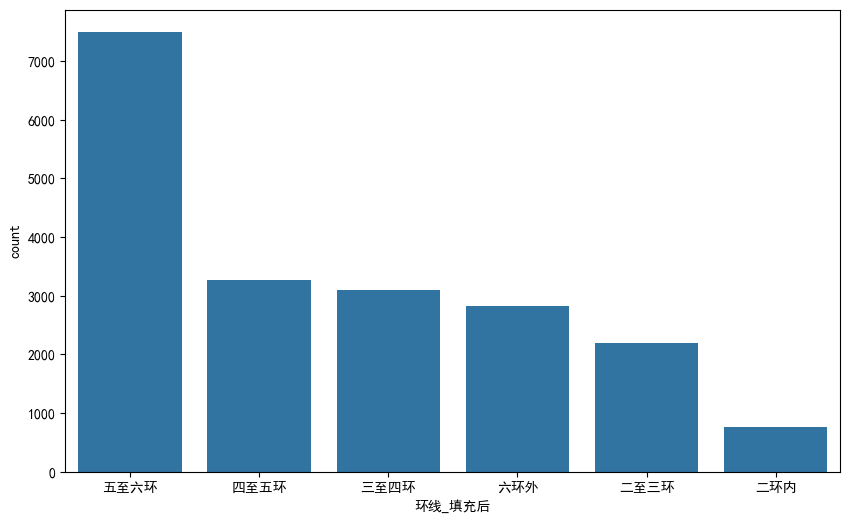

In [13]:
# 通过观察，我们发现不同城市的‘二至三环’等具有不同含义，因此必须按照城市内编码
# 另外发现：城市1和5的数据中都没有环线位置的数据，下一步我们看看环线位置”缺失的房产按城市分布情况

plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False   # 解决保存图像是负号'-'显示为方块的问题

target_city = 0
city_df = full[full['城市'] == target_city].copy()
ring_counts = city_df['环线_填充后'].value_counts()
plt.figure(figsize=(10, 6)) # 设置图像大小
sns.countplot(data=city_df, x='环线_填充后', order=ring_counts.index)



In [14]:
# 对于少量缺失的城市，使用KNN来预测环线位置。1和5比较特殊，1和5需要使用特殊的预测方式

missing_ring_location_df = full[full['环线_填充后'].isnull()]

city_counts_for_missing = missing_ring_location_df['城市'].value_counts()
print("“环线位置”缺失的房产按城市分布情况：")
print(city_counts_for_missing)
print("-" * 30)



“环线位置”缺失的房产按城市分布情况：
城市
5    11085
1     5696
2     5469
6      995
0      331
3       37
4       17
Name: count, dtype: int64
------------------------------


In [15]:
# 拟合KNN，并寻找最佳的N

df_imputed_list = []

le_ring_location = LabelEncoder()
known_ring_locations = full['环线_填充后'].dropna().unique()
le_ring_location.fit(known_ring_locations)
full['环线位置_encoded'] = full['环线_填充后'].apply(lambda x: le_ring_location.transform([x])[0] if pd.notnull(x) else np.nan)

imputation_features = ['区域', 'lon', 'lat']

#寻找最佳的N
cities_for_k_eval =[0,2,3,4,6]
k_range_to_test = [1, 3, 5, 7,9,15]
target_col_name = '环线_填充后'
target_col_encoded_name = '环线位置_encoded'
if len(cities_for_k_eval) > 0 and target_col_encoded_name in full.columns:
    optimal_k, _ = find_optimal_k_for_imputation(
        full, cities_for_k_eval, k_range_to_test,
        imputation_features, target_col_encoded_name
    )
else:
    print("没有合适的城市用于K值评估或目标列未编码，使用默认K=5。")
    optimal_k = 5
print(optimal_k)

for city in [0,2,3,4,6]:
    city_df = full[full['城市'] == city].copy()
    train_imp_df = city_df.dropna(subset=['环线位置_encoded']) # 有环线位置的
    target_imp_df = city_df[city_df['环线位置_encoded'].isnull()] # 缺失环线位置的

    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'), ['区域']), # 忽略测试集中未见过的区域类别
            ('scaler', StandardScaler(), ['lon', 'lat'])
        ],
        remainder='passthrough' 
    )

    X_train_imp = train_imp_df[imputation_features]
    y_train_imp = train_imp_df['环线位置_encoded']

    X_target_imp = target_imp_df[imputation_features]

    X_train_imp_processed = preprocessor.fit_transform(X_train_imp)
    X_target_imp_processed = preprocessor.transform(X_target_imp)

    k_neighbors =3

    knn_classifier = KNeighborsClassifier(n_neighbors=k_neighbors)
    knn_classifier.fit(X_train_imp_processed, y_train_imp)

    predicted_ring_location_encoded = knn_classifier.predict(X_target_imp_processed)

    imputed_values_series = pd.Series(predicted_ring_location_encoded, index=target_imp_df.index)
    city_df.loc[target_imp_df.index, '环线位置_encoded'] = imputed_values_series
    
    df_imputed_list.append(city_df)





评估城市 '0' (已知数据: 19641)...
评估城市 '2' (已知数据: 22014)...
评估城市 '3' (已知数据: 7809)...
评估城市 '4' (已知数据: 8724)...
评估城市 '6' (已知数据: 17101)...

各K值平均准确率:
  K=1: 0.9990 (基于 5 个城市的评估)
  K=3: 0.9979 (基于 5 个城市的评估)
  K=5: 0.9966 (基于 5 个城市的评估)
  K=7: 0.9943 (基于 5 个城市的评估)
  K=9: 0.9933 (基于 5 个城市的评估)
  K=15: 0.9899 (基于 5 个城市的评估)
--- 最优K值确定为: 1 (平均准确率: 0.9990) ---

1


In [16]:
df_final_imputed = pd.concat(df_imputed_list).sort_index()
if '环线位置_encoded' in df_final_imputed.columns and hasattr(le_ring_location, 'classes_'):
        df_final_imputed['环线位置_imputed_text'] = df_final_imputed['环线位置_encoded'].apply(
            lambda x: le_ring_location.inverse_transform([int(x)])[0] if pd.notnull(x) else np.nan
        )
        # 你可以选择用插补后的文本替换原始'环线位置'列，或者保留编码列和文本列
        df_final_imputed['环线_填充后'] = df_final_imputed['环线位置_imputed_text']
        df_final_imputed = df_final_imputed.drop(columns=['环线位置_encoded', '环线位置_imputed_text'])

In [17]:
full=full.drop(columns=['环线位置_encoded'])
full.update(df_final_imputed)


In [18]:
# 稍后会发现：1和5尽管所有样本环线都缺失，但不代表它们不具有相应的位置特征

full=full.apply(assign_ring,axis=1)
full=full.apply(assign_ring5,axis=1)

In [19]:
full[full['城市']==5 ]['环线_填充后'].to_csv('out.csv')

In [20]:
# full['环线_填充后'].fillna('未知') 
#  对于城市1和5，也许还有更好的办法

train1=full.iloc[:84133]
test1=full.iloc[84133:]

# 为环线位置使用目标编码

city_col = '城市'
ring_col = '环线_填充后'
target_col = '价格'
new_encoded_col_name = '环线'

smoothing_weight = 10

encodings_map_trained, city_means_map_trained, global_mean_trained = \
    fit_grouped_target_encoder(train1, city_col, ring_col, target_col, smoothing_weight)

train1[new_encoded_col_name] = transform_with_grouped_target_encoder(
    train1, city_col, ring_col, 
    encodings_map_trained, city_means_map_trained, global_mean_trained
)

test1[new_encoded_col_name] = transform_with_grouped_target_encoder(
    test1, city_col, ring_col,
    encodings_map_trained, city_means_map_trained, global_mean_trained # 使用从训练集得到的映射
)

temp=pd.concat([train1,test1])
full['环线_填充后']=temp['环线']


--- 正在从提供的数据集计算目标编码映射 (基于 '价格') ---
目标编码映射计算完毕。

--- 正在对提供的数据集应用已计算的编码映射 ---


C:\Windows\Temp\ipykernel_15260\1085195337.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train1[new_encoded_col_name] = transform_with_grouped_target_encoder(



--- 正在对提供的数据集应用已计算的编码映射 ---


C:\Windows\Temp\ipykernel_15260\1085195337.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1[new_encoded_col_name] = transform_with_grouped_target_encoder(


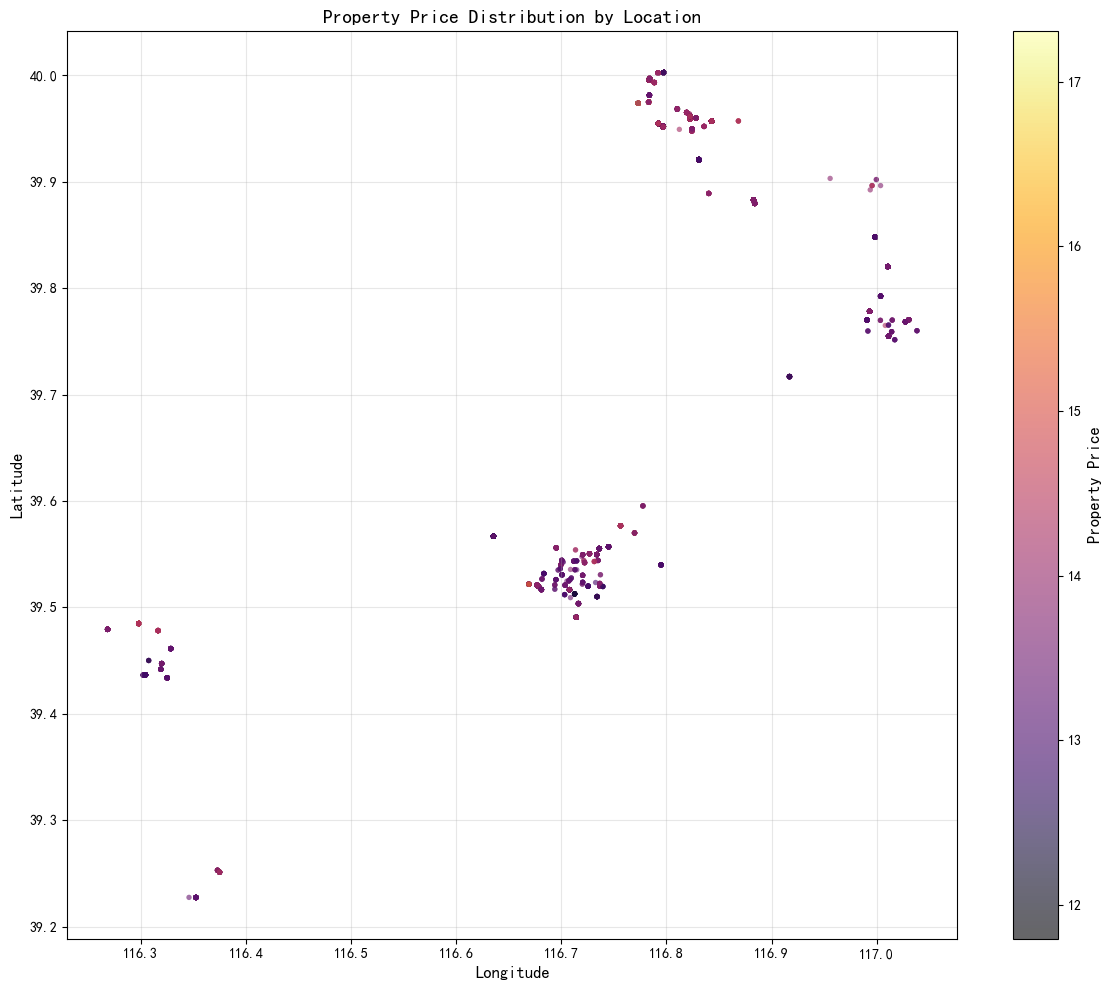

In [21]:
# 城市1和5不具有而明显的市中心，但我们可以按照经纬度大致分为几个区块

train1=full.iloc[:84133]
test1=full.iloc[84133:]

city=1
data = train1[train1['城市'] == city].copy()

plt.figure(figsize=(12, 10))

scatter = plt.scatter(
    x=data['lon'],
    y=data['lat'],
    c=np.log1p(data['价格']),
    cmap='inferno',        # 使用viridis色图（低价：紫色→蓝色，高价：黄色）
    alpha=0.6,             # 设置透明度便于观察重叠点
    s=15,                  # 点的大小
    edgecolors='none'      # 去掉点边缘线
)

cbar = plt.colorbar(scatter)
cbar.set_label('Property Price', fontsize=12)

plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('Property Price Distribution by Location', fontsize=14)

plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

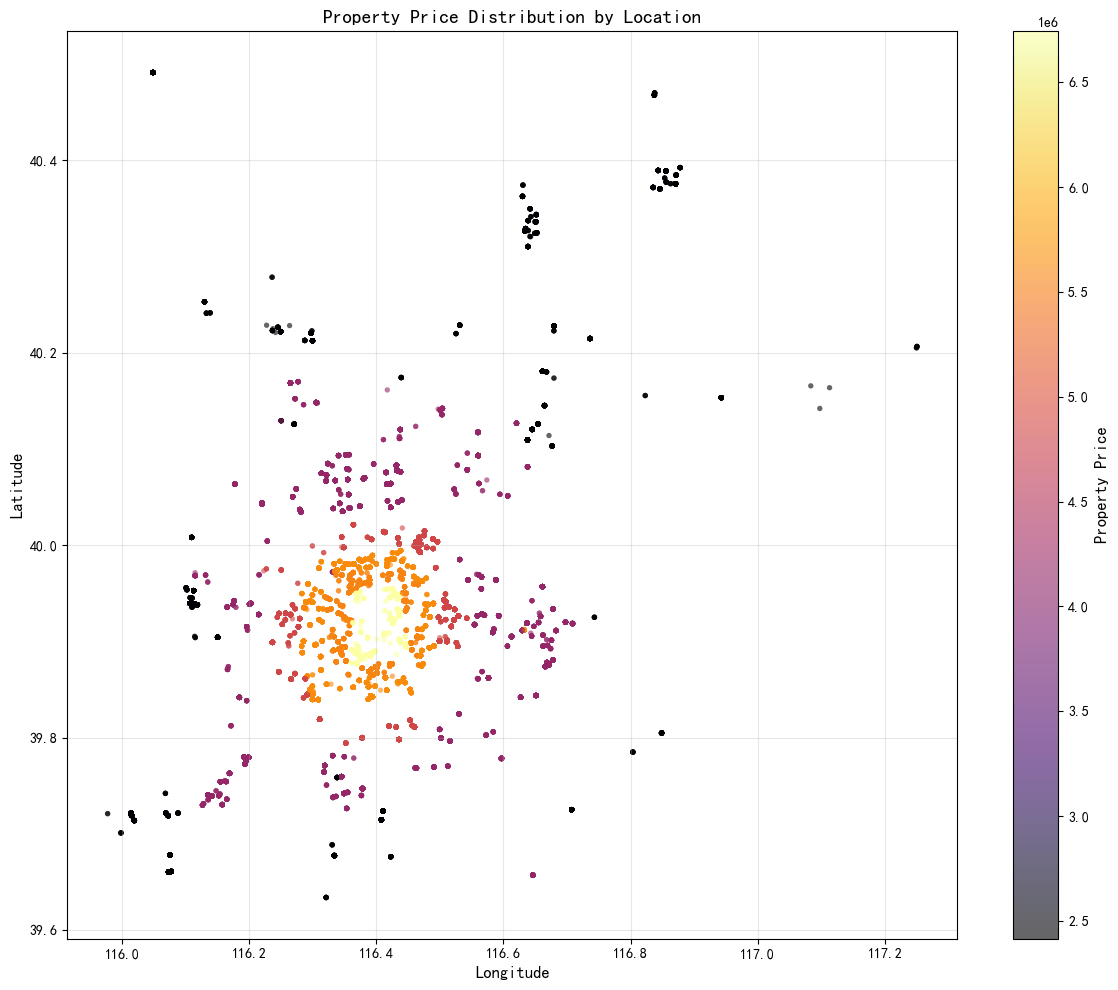

In [22]:
# 添加需要预测的数据，检验划分是否合理
# 从这个图可以看出，用KNN的效果很准确

train1=full.iloc[:84133]
test1=full.iloc[84133:]

city=0
data = full[full['城市'] == city].copy()

plt.figure(figsize=(12, 10))

scatter = plt.scatter(
    x=data['lon'],
    y=data['lat'],
    c=data['环线_填充后'],
    cmap='inferno',        # 使用viridis色图（低价：紫色→蓝色，高价：黄色）
    alpha=0.6,             # 设置透明度便于观察重叠点
    s=15,                  # 点的大小
    edgecolors='none'      # 去掉点边缘线
)

cbar = plt.colorbar(scatter)
cbar.set_label('Property Price', fontsize=12)

plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('Property Price Distribution by Location', fontsize=14)

plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
# 我们发现：城市1和5不具有环线变量，是因为它们的数据可能来自县镇；我们可以按照经纬度将两个城市分成几部分，来表现它们的地理特征
# 已将改进后的代码整合到上面代码


# 其余特征

In [24]:
def extracts(text):
    if pd.isnull(text)==False:
        numbers=list(map(float, re.findall(r'\d+\.?\d*', text)))
        if len(numbers)==4:
            return numbers
        elif len(numbers)==2:
            if numbers[0]>1:
                return [numbers[0],  1, 1 ,numbers[1]]
            else:
                return [numbers[0],  0, 0 ,numbers[1]]
        elif len(numbers)==1:
            return numbers[0]

    else:
        return [0,0,0,0]
extracts("89㎡   " )

# 计算卫室比

def shiwei(a,b):
    if a==None or b==None or a==0:
        return 0
    else:
        return b/a

In [25]:
# 提取梯户比例、梯、户

def chinese_to_arabic(text):
    # 中文数字到阿拉伯数字的映射
    chinese_to_arabic = {
        '零': 0, '一': 1, '二': 2, '三': 3, '四': 4,
        '五': 5, '六': 6, '七': 7, '八': 8, '九': 9,
        '十': 10, '百': 100, '千': 1000, '万': 10000,
        '两':2
    }
    
    total = 0
    temp = 0
    for char in text:
        if char in chinese_to_arabic:
            value = chinese_to_arabic[char]
            if value >= 10:  # 单位字符（如 "十", "百"）
                if temp == 0:  # 如果没有前导数字，默认为 1（如 "十二" 等价于 "一十二"）
                    temp = 1
                temp *= value
                total += temp
                temp = 0
            else:  # 数字字符（如 "一", "二"）
                temp = value
    total += temp  # 处理最后的数字
    return total

def ti_hu(text):
    if pd.isnull(text)==False:
        parts=text.split("梯")
        ti=chinese_to_arabic(parts[0])
        hu=chinese_to_arabic(parts[1].rstrip("户"))
        return ti/hu
    
def ti(text):
    if pd.isnull(text)==False:
        parts=text.split("梯")
        ti=chinese_to_arabic(parts[0])
        return ti
    
def hu(text):
    if pd.isnull(text)==False:
        parts=text.split("梯")
        hu=chinese_to_arabic(parts[1].rstrip("户"))
        return hu

ti_hu("一梯四户")

0.25

In [26]:
# 规整房屋朝向

def chao_xiang(text):
    words= text.split(" ")
    sort=sorted(words)
    normal=' '.join(sort)

    return normal

chao_xiang("南北 东 西")

'东 南北 西'

In [27]:
# 应用分箱结果

def apply_bins(data, bins):

    # 预测集可能出现新的最大最小值

    adjusted_bins = bins.copy()
    adjusted_bins[0] = -np.inf
    adjusted_bins[-1] = np.inf

    data=pd.cut(data, bins=adjusted_bins, labels=False, duplicates='drop')

    return data

In [28]:
# 提取物业费

def wu_ye(text):
    if pd.isnull(text)==False:
        numbers = list(map(float, re.findall(r'-?\d+\.?\d*', text)))
        if len(numbers) == 1:
            return numbers[0]  # 只有一个数字，直接返回
        elif len(numbers) == 2:
            if numbers[1]-numbers[0]>10: # 自动编码器发现异常，添加处理逻辑
                return numbers[0]
            else:
                return (numbers[0]-numbers[1]) / 2  # 两个数字，返回均值

wu_ye("1.2-2.3")

1.75

In [29]:
# 提取房本数据

def fang_ben(advantage_str):
    # 转换为字符串以防原始数据中有非字符串类型的值
    advantage_str = str(advantage_str)
    if '房本满五年' in advantage_str:
        return '满五年'
    elif '房本满两年' in advantage_str:
        return '满两年'
    else:
        return '未知' # 如果没有明确的房本年限信息

In [30]:
# 提取交易时间信息，以反应交易当时的市场行情

def shijian1 (time):
    parts=time.split('-')

    return int(parts[0])

def shijian2 (time):
    parts=time.split('-')

    return int(parts[1])

def shijian3 (time):
    parts=time.split('-')

    return int(parts[2])



In [31]:
# 计算挂牌时间，因为挂牌时间越长可能反映了某些隐藏的缺点，导致长期卖不出去

def calculate_time_difference(start_date, end_date):
    """
    计算两个日期之间的时间差
    
    参数:
    start_date (str): 开始日期，格式为 'YYYY-MM-DD' 或 'YYYY-M-D'
    end_date (str): 结束日期，格式为 'YYYY-MM-DD' 或 'YYYY-M-D'
    
    返回:
    dict: 包含多种时间间隔单位的字典（天、周、月、年）
    """
    # 将字符串转换为日期对象
    if pd.isna(start_date):
        return 0
    else:
        format_str = '%Y-%m-%d'
        date_format = datetime.strptime
        start_dt = date_format(start_date, format_str)
        end_dt = date_format(end_date, format_str)


        months = (end_dt.year - start_dt.year) * 12 + (end_dt.month - start_dt.month)
        if months<0:
            return 0
        else:
            return round(months,1)

print(calculate_time_difference('2001-01-14','2025-12-31'))
print(calculate_time_difference(None,'2025-12-31'))

299
0


In [32]:
# 计算楼栋密度

def midu(wu,dong):
    if pd.isna(wu) or pd.isna(dong):
        return None
    else:
        return wu/dong

In [33]:
# 交易时间、上次交易
# 经济的宏观数据可能受到年度、季度的影响
# 另外，长期卖不出求也有可能影响价格；尽管这里并非真正的挂牌时间而是两次交易之间的时间差

full['交易年份']=full['交易时间'].apply(shijian1)
full['交易月份']=full['交易时间'].apply(shijian2)


full['挂牌时间']=full.apply(lambda row:calculate_time_difference(row['上次交易'],row['交易时间']),axis=1)

full=full.drop(columns=['交易时间','上次交易'])

In [34]:
# 房屋户型

huxing=full['房屋户型'].apply(extracts)
full= pd.concat([full, pd.DataFrame(huxing.tolist(), columns=['户型_室', '户型_厅', '户型_厨', '户型_卫'])], axis=1)
full.drop(columns=['房屋户型'], inplace=True)
full['总房屋']=full['户型_室']+full['户型_厅']+full['户型_厨']+full['户型_卫']



In [35]:
# 卫生间数和房间数的比值相当重要
# 在这里恰好两者的数据都是相当准确的（几乎没有缺失）

full['卫室比']=full.apply(lambda row:shiwei(row['户型_室'],row['户型_卫']),axis=1)

In [36]:
# 所在楼层

regex_pattern = r'^(.*?)\s*\(共(\d+)层\)'
extracted_parts = full['所在楼层'].str.extract(regex_pattern)
extracted_parts.columns = ['楼层位置', '总层数']
full=pd.concat([full, extracted_parts], axis=1)
full['总层数'] = full['总层数'].astype(int)
full.drop(columns=['所在楼层'], inplace=True)



In [37]:
# 建筑面积

full['建筑面积'] = full['建筑面积'].apply(extracts)
full['套内面积']=full['套内面积'].fillna('0')
full['套内面积']=full['套内面积'].apply(extracts)

In [38]:
# 房屋朝向

full['房屋朝向'] = full['房屋朝向'].apply(chao_xiang)


In [39]:
# 梯户比例
full['梯']=full['梯户比例'].apply(ti)
full['户']=full['梯户比例'].apply(hu)
full['梯户比例']= full['梯户比例'].apply(ti_hu)

In [40]:
# 别墅类型

full['别墅类型'] = full['别墅类型'].fillna('非别墅')

In [41]:
# 房屋优势
# 为三部分：装修、地铁、房本。第一个已有明确特征，故在此略去。

full['有无地铁'] = full['房屋优势'].apply(lambda x: '有' if '地铁' in str(x) else '无')
full['房本']=full['房屋优势'].apply(fang_ben)
full.drop(columns=['房屋优势'], inplace=True)



In [42]:
# 开发商：将出现次数小于阈值的归类为“其它”
# 后来发现是多此一举

threshold = 10  # 设置阈值

developer_counts = full['开发商'].value_counts()
infrequent_developers = developer_counts[developer_counts < threshold].index.tolist()
'''''
full['开发商'] = full['开发商'].apply(lambda x: x if x not in infrequent_developers else '其它')
full['开发商'] = full['开发商'].apply(lambda x: x if x !='无开发商' and x !='无开发公司' else '无')
'''

"''\nfull['开发商'] = full['开发商'].apply(lambda x: x if x not in infrequent_developers else '其它')\nfull['开发商'] = full['开发商'].apply(lambda x: x if x !='无开发商' and x !='无开发公司' else '无')\n"

In [43]:
# 房屋总数、楼栋总数：先将取值变为数值变量,将数据类型变为整数
# 同样是多此一举



full['房屋总数']= full['房屋总数'].apply(lambda x:re.findall(r'\d+', str(x)))
full['楼栋总数']= full['楼栋总数'].apply(lambda x:re.findall(r'\d+', str(x)))
full['房屋总数'] = full['房屋总数'].apply(lambda x: int(x[0]) if x else np.nan)
full['楼栋总数'] = full['楼栋总数'].apply(lambda x: int(x[0]) if x else np.nan)

# 楼栋密度：即每栋楼的住户，可能反映小区的设计，从而体现房价
full['楼栋密度']=full.apply(lambda row:midu(row['房屋总数'],row['楼栋总数']),axis=1)

# 防止数据泄露，用train做分箱，再处理test
train1=full.iloc[:84133]
test1=full.iloc[84133:]

'''''
train1['小区房屋']=pd.qcut(train1['房屋总数'],q=20,labels=False,duplicates='drop')
_, bins = pd.qcut(train1['房屋总数'], q=20, retbins=True, duplicates='drop')
test1['小区房屋']=apply_bins(test1['房屋总数'], bins)
full=pd.concat([train1, test1], ignore_index=True)

train1['小区楼栋']=pd.qcut(train1['楼栋总数'],q=20,labels=False,duplicates='drop')
_, bins = pd.qcut(train1['楼栋总数'], q=20, retbins=True, duplicates='drop')
test1['小区楼栋']=apply_bins(test1['楼栋总数'], bins)
full=pd.concat([train1, test1], ignore_index=True)

full.drop(columns=['房屋总数','楼栋总数'], inplace=True)
'''


"''\ntrain1['小区房屋']=pd.qcut(train1['房屋总数'],q=20,labels=False,duplicates='drop')\n_, bins = pd.qcut(train1['房屋总数'], q=20, retbins=True, duplicates='drop')\ntest1['小区房屋']=apply_bins(test1['房屋总数'], bins)\nfull=pd.concat([train1, test1], ignore_index=True)\n\ntrain1['小区楼栋']=pd.qcut(train1['楼栋总数'],q=20,labels=False,duplicates='drop')\n_, bins = pd.qcut(train1['楼栋总数'], q=20, retbins=True, duplicates='drop')\ntest1['小区楼栋']=apply_bins(test1['楼栋总数'], bins)\nfull=pd.concat([train1, test1], ignore_index=True)\n\nfull.drop(columns=['房屋总数','楼栋总数'], inplace=True)\n"

In [44]:
# 物业公司:与开发商类似，出现次数小于阈值的归类为“其它”
# 多此一举

threshold = 10  # 设置阈值,交叉验证效果

developer_counts = full['物业公司'].value_counts()
infrequent_developers = developer_counts[developer_counts < threshold].index.tolist()
'''''
full['物业公司'] = full['物业公司'].apply(lambda x: x if x not in infrequent_developers else '其它')
'''

"''\nfull['物业公司'] = full['物业公司'].apply(lambda x: x if x not in infrequent_developers else '其它')\n"

In [45]:
# 绿 化 率

full['绿 化 率']= full['绿 化 率'].apply(lambda x:re.findall(r'\d+', str(x)))
full['绿 化 率'] = full['绿 化 率'].apply(lambda x: int(x[0]) if x else np.nan)

In [46]:
# 物 业 费、燃气费

full['物 业 费'] = full['物 业 费'].apply(wu_ye)
full['燃气费'] = full['燃气费'].apply(wu_ye)
full['供热费'] = full['供热费'].apply(wu_ye)

In [47]:
# 停车位

train1=full.iloc[:84133]
test1=full.iloc[84133:]

'''''
train1['停车位']=pd.qcut(train1['停车位'],q=20,labels=False,duplicates='drop')
_, bins = pd.qcut(train1['停车位'], q=20, retbins=True, duplicates='drop')
test1['停车位']=apply_bins(test1['停车位'], bins)
full=pd.concat([train1, test1], ignore_index=True)
'''

"''\ntrain1['停车位']=pd.qcut(train1['停车位'],q=20,labels=False,duplicates='drop')\n_, bins = pd.qcut(train1['停车位'], q=20, retbins=True, duplicates='drop')\ntest1['停车位']=apply_bins(test1['停车位'], bins)\nfull=pd.concat([train1, test1], ignore_index=True)\n"

# 填补缺失值

In [48]:
# 随机插补

def uniform_random_fill(series):
    """单行代码实现均匀随机填补"""
    return series.apply(
        lambda x: np.random.choice(series.dropna().unique()) if pd.isnull(x) else x
    )

In [49]:
# 不同编码函数:对类别大于15的使用标签编码，对类别小于等于15的使用独热编码
# 最终并未用到独热编码

def auto_encode(df, column, threshold=15):

    n_categories = df[column].nunique()

    if n_categories <= threshold:
        
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded = encoder.fit_transform(df[[column]])
        encoded_df = pd.DataFrame(encoded, columns=[f"{column}_{cat}" for cat in encoder.categories_[0]])
        df = pd.concat([df, encoded_df], axis=1)
        df = df.drop(columns=[column])


    else:
        
        encoder = LabelEncoder()
        df[column] = encoder.fit_transform(df[column])

    return df




In [50]:
# 众数填充

def fill_na_with_mode(series):
    # 计算众数。Pandas的mode()可能返回多个众数，我们取第一个
    # 如果所有值都是NaN，mode()会返回一个空Series
    mode_val = series.mode()
    if not mode_val.empty:
        return series.fillna(mode_val[0])
    return series # 如果没有众数（比如组内全是NaN），则不改变原系列

In [51]:
# 建筑结构、装修情况：注意到样本同时在这两项取得缺失，说明可能缺失的是同一类样本，故用新的一类填充

full['建筑结构'] = full['建筑结构'].fillna('未知')
full['装修情况'] = full['装修情况'].fillna('未知')

In [52]:
# 配备电梯、梯户比例矫正
"""
梯户比例      1.998605
配备电梯      9.718052
"""

# 一般来说，总层数大于7的会配备电梯，反之则不会
full.loc[full['总层数']> 7, '配备电梯'] = '有'
full.loc[full['总层数']<= 7, '配备电梯'] = '无'


full.loc[full['梯户比例'] >0, '配备电梯'] = '有'
full.loc[full['配备电梯'] =='无', '梯户比例'] = 0



In [53]:
# 然而仍然存在缺失，使用同小区的数据填补

full['梯户比例'] = full.groupby(['小区名称', '板块_x'])['梯户比例'].transform(fill_na_with_mode)
full['梯户比例'] =full['梯户比例'].fillna(0) # 对于树模型来说相当于是赋予额外的类别

In [54]:
# 我们同样可以这样处理房屋年限，即认为同一小区的房屋年限大部分都是相同的

full['房屋年限'] = full.groupby(['小区名称', '板块_x'])['房屋年限'].transform(fill_na_with_mode)

In [55]:
# 用同一板块的填补


full['供热费'] = full.groupby([ '板块_x'])['供热费'].transform(fill_na_with_mode)

In [56]:
# 填充其余缺失值:房屋用途、房屋年限、绿 化 率、容 积 率、物 业 费、供水、供电、燃气费、停车位、小区房屋、小区楼栋
# 常规填充办法：众数或中位数
train2=full.iloc[:84133]
test2=full.iloc[84133:]

num_cols = ['绿 化 率', '容 积 率', '物 业 费', '燃气费','楼栋密度','房屋总数','楼栋总数','停车位','供热费','梯','户']
for col in num_cols:
    train2[col] = train2[col].fillna(train2[col].median())
    test2[col] = test2[col].fillna(test2[col].median())

cat_cols = ['房屋用途', '房屋年限', '开发商', '物业公司', '供水', '供电']
for col in cat_cols:
    train2[col] = train2[col].fillna(train2[col].mode()[0])
    test2[col] = test2[col].fillna(test2[col].mode()[0])

# 下面三个特征进行了分箱处理，随机插值即可 
'''''
train2['小区房屋'] =uniform_random_fill(train2['小区房屋'])
test2['小区房屋'] =uniform_random_fill(test2['小区房屋'])
train2['小区楼栋'] =uniform_random_fill(train2['小区楼栋'])
test2['小区楼栋'] =uniform_random_fill(test2['小区楼栋'])
train2['停车位']=uniform_random_fill(train2['停车位'])
test2['停车位']=uniform_random_fill(test2['停车位'])
'''

C:\Windows\Temp\ipykernel_15260\4214723508.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train2[col] = train2[col].fillna(train2[col].median())
C:\Windows\Temp\ipykernel_15260\4214723508.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2[col] = test2[col].fillna(test2[col].median())
C:\Windows\Temp\ipykernel_15260\4214723508.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

"''\ntrain2['小区房屋'] =uniform_random_fill(train2['小区房屋'])\ntest2['小区房屋'] =uniform_random_fill(test2['小区房屋'])\ntrain2['小区楼栋'] =uniform_random_fill(train2['小区楼栋'])\ntest2['小区楼栋'] =uniform_random_fill(test2['小区楼栋'])\ntrain2['停车位']=uniform_random_fill(train2['停车位'])\ntest2['停车位']=uniform_random_fill(test2['停车位'])\n"

In [57]:
# full2是所有特征都不具有缺失值的数据

full2 = pd.concat([train2, test2], ignore_index=True)


In [58]:
# 补充特征

full2['舒适程度']=full2['绿 化 率']/full2['容 积 率']

# 二、手动编码

In [59]:
# 为了防止维度爆炸，有必要对一些分类变量的类别进行进一步的处理

full3=full2.copy()
category_columns = ['房屋朝向', '建筑结构', '装修情况', '配备电梯', '别墅类型', '交易权属', '房屋用途', '房屋年限', '产权所属', '开发商', '物业公司', '供水', '供电',  '楼层位置', '有无地铁', '房本']


C:\Windows\Temp\ipykernel_15260\1835786856.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categorical_feature_column, y='价格', data=mean_prices, palette='coolwarm', order=mean_prices[categorical_feature_column])


([0, 1, 2], [Text(0, 0, '满五年'), Text(1, 0, '满两年'), Text(2, 0, '未知')])

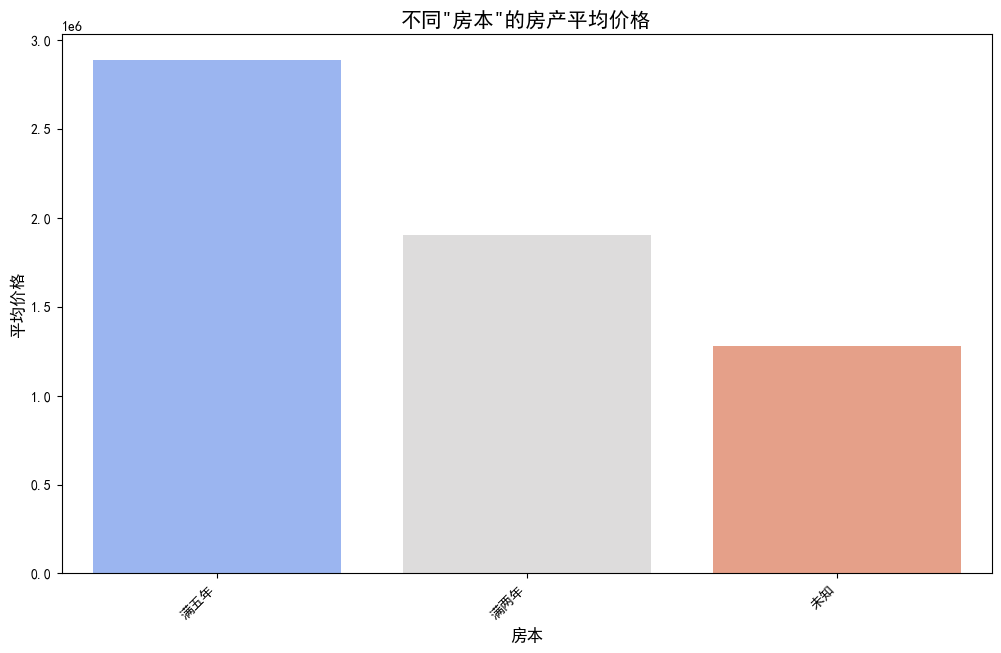

In [60]:
# 我们希望知道不同类别的潜在价格关系，事实上这可以来源于先验的常识。

train1=full.iloc[:84133]
test1=full.iloc[84133:]

categorical_feature_column ='房本'

mean_prices = train1.groupby(categorical_feature_column)['价格'].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 7))
sns.barplot(x=categorical_feature_column, y='价格', data=mean_prices, palette='coolwarm', order=mean_prices[categorical_feature_column])
plt.title(f'不同"{categorical_feature_column}"的房产平均价格', fontsize=15)
plt.xlabel(categorical_feature_column, fontsize=12)
plt.ylabel('平均价格', fontsize=12)
plt.xticks(rotation=45, ha='right')


In [61]:
# 根据组内价格均值顺序编码，并合并相似且数量少的类

bianma={
    '交易月份':{
        1:1,
        2:1,
        3:1,
        4:2,
        5:2,
        6:2,
        7:3,
        8:3,
        9:3,
        10:4,
        11:4,
        12:4
    },
    '楼层位置':{
        '地下室':0,
        '高楼层':1,
        '中楼层':2,
        '低楼层':3,
        '顶层':4,
        '底层':5
    },
    '建筑结构':{
        '未知':0,
        '砖木结构':1,
        '砖混结构':5,
        '混合结构':7,
        '钢结构':4,
        '框架结构':2,
        '钢混结构':6,
        '未知结构':3,
    },

    '装修情况':{
        '毛坯':2,
        '简装':3,
        '精装':4,
        '其他':1,
        '未知':0
    },

    '配备电梯':{
        '有':1,
        '无':0
    }, 
    
    '别墅类型':{
        '叠拼':1,
        '联排':2,
        '双拼':3,
        '独栋':4,
        '非别墅':0
    }, 
    
    '交易权属':{
        '自住型商品房':13,
        '售后公房':8,
        '使用权':0,
        '定向安置房':12,
        '房改房':4,
        '央产房':15,
        '集资房':3,
        '私产':9,
        '限价商品房':6,
        '动迁安置房':7,
        '一类经济适用房':11,
        '经济适用房':2,
        '二类经济适用房':14,
        '拆迁还建房':1,
        '已购公房':10,
        '商品房':5

    },
    '房屋年限':{
        '满五年':2,
        '满两年':1,
        '未满两年':0

    },
    '产权所属':{
        '共有':1,
        '非共有':0
    },
    '房屋用途':{
        '普通住宅':2,
        '商业办公类':1,
        '别墅':7,
        '商住两用':0,
        '车库':0,
        '公寓':10,
        '写字楼':3,
        '底商':1,
        '商业':1,
        '酒店式公寓':9,
        '公寓/公寓':10,
        '公寓/住宅':4,
        '新式里弄':5,
        '四合院':8,
        '公寓（住宅）':10,
        '老公寓':10,
        '住宅式公寓':0,
        '平房':6,
        '花园洋房':10
    },
    "供水":{
        '民水':2,
        '商水/民水':1,
        '商水':0
    },
    '供电':{
        '民电':2,
        '商电/民电':1,
        '商电':0

    },
    '有无地铁':{
        '有':1,
        '无':0
    },
    '房本':{
        '未知':0,
        '满两年':1,
        '满五年':2
    }
}
full3=full2.replace(bianma)

C:\Windows\Temp\ipykernel_15260\3131196037.py:129: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full3=full2.replace(bianma)


In [62]:
# 这一部分是想要像环线位置一样处理区域、板块，发现过拟合，舍去

'''''
train2=full3.iloc[:84133]
test2=full3.iloc[84133:]

global_mean_price = train2['价格'].median()
plate_price_map = train2.groupby('板块_x')['价格'].median()

train2['板块_x'] = train2['板块_x'].map(plate_price_map)
test2['板块_x'] = test2['板块_x'].map(plate_price_map)
test2['板块_x'].fillna(global_mean_price, inplace=True)
'''

"''\ntrain2=full3.iloc[:84133]\ntest2=full3.iloc[84133:]\n\nglobal_mean_price = train2['价格'].median()\nplate_price_map = train2.groupby('板块_x')['价格'].median()\n\ntrain2['板块_x'] = train2['板块_x'].map(plate_price_map)\ntest2['板块_x'] = test2['板块_x'].map(plate_price_map)\ntest2['板块_x'].fillna(global_mean_price, inplace=True)\n"

In [63]:
'''''

global_mean_price = train2['价格'].median()
plate_price_map = train2.groupby('区域')['价格'].median()

train2['区域'] = train2['区域'].map(plate_price_map)
test2['区域'] = test2['区域'].map(plate_price_map)
test2['区域'].fillna(global_mean_price, inplace=True)
full3=pd.concat([train2,test2])
'''

"''\n\nglobal_mean_price = train2['价格'].median()\nplate_price_map = train2.groupby('区域')['价格'].median()\n\ntrain2['区域'] = train2['区域'].map(plate_price_map)\ntest2['区域'] = test2['区域'].map(plate_price_map)\ntest2['区域'].fillna(global_mean_price, inplace=True)\nfull3=pd.concat([train2,test2])\n"

In [64]:
# 剩下的房屋朝向、开发商、物业公司，交给标签编码


category_columns = ['房屋朝向' ,'开发商', '物业公司']

le = LabelEncoder()
for col in category_columns:
    full3[col]=le.fit_transform(full3[col])

In [65]:
# 还有小区

full3['小区'] = full3['区域'].astype(str) + '_' + full3['小区名称']
le = LabelEncoder()
full3['小区'] = le.fit_transform(full3['小区'])

In [68]:
# 下面构建自动编码器，识别异常值

full4=full3.copy()
full4=full4.drop(columns=['价格','小区名称'])

# 自动编码器

In [69]:
# 自动编码器，识别异常值

train4=full4.iloc[:84133]
test4=full4.iloc[84133:]


scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(train4)


X_train, X_val  = train_test_split(data_scaled, test_size=0.2, random_state=42)


input_dim = X_train.shape[1]
encoding_dim = input_dim

input_layer = keras.Input(shape=(input_dim,))
encoder = layers.Dense(encoding_dim, activation='relu')(input_layer)

decoder = layers.Dense(input_dim, activation='sigmoid' if isinstance(scaler, MinMaxScaler) else 'linear')(encoder)
autoencoder = keras.Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 49)             │         2,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 49)             │         2,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,900 (19.14 KB)

 Trainable params: 4,900 (19.14 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
early_stopping = EarlyStopping(monitor='val_loss', # 监控验证集损失
                               patience=5,        # 10个epoch验证集损失没有改善则停止
                               restore_best_weights=True) # 恢复最佳权重

history = autoencoder.fit(X_train, X_train,  # 输入和目标相同
                          epochs=100,         # 训练轮数，可以调整
                          batch_size=32,      # 批大小，可以调整
                          shuffle=True,
                          validation_data=(X_val, X_val), # 使用验证集
                          callbacks=[early_stopping] if X_val.shape[0] > 0 else [], # 如果有验证集则使用早停
                          verbose=1) # 打印训练过程




Epoch 1/100
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0305 - val_loss: 0.0026
Epoch 2/100
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 3/100
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9.4562e-04 - val_loss: 7.0826e-04
Epoch 4/100
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.6391e-04 - val_loss: 5.8787e-04
Epoch 5/100
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.5400e-04 - val_loss: 5.0851e-04
Epoch 6/100
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.8459e-04 - val_loss: 4.6825e-04
Epoch 7/100
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.5858e-04 - val_loss: 4.5474e-04
Epoch 8/100
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.4831e-04 - val_loss: 4.4832e-04
Epoch 9/100
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.3767e-04 - val_loss: 4.3376e-04
Epoch 10/100
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.3057e-04 - val_loss: 4.3018e-04
Epoch 11/100
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 2

2630/2630 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step


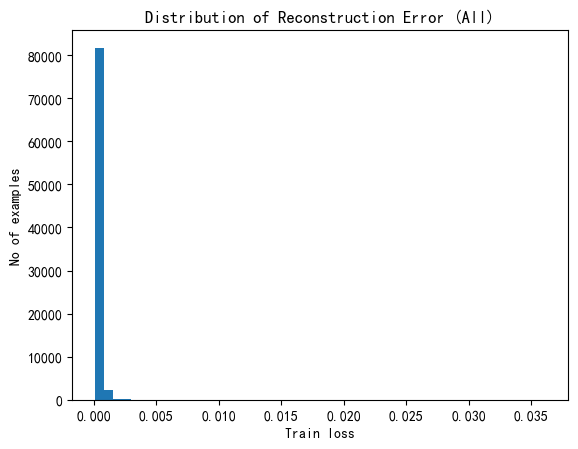

In [71]:
reconstructions_train = autoencoder.predict(data_scaled)
train_loss = tf.keras.losses.mse(reconstructions_train, data_scaled)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.title("Distribution of Reconstruction Error (All)")
plt.show()

In [72]:
threshold = np.percentile(train_loss, 99.9)
print(f"设定的异常值阈值 (基于95百分位数): {threshold}")

outliers_train_indices = np.where(train_loss > threshold)[0]
normal_train_indices = np.where(train_loss <= threshold)[0]

print(f"在X_train中识别到 {len(outliers_train_indices)} 个异常值。")

data_all=scaler.fit_transform(full4)
all_reconstructions = autoencoder.predict(data_scaled)
all_losses = tf.keras.losses.mse(all_reconstructions, data_scaled)

outlier_indices = np.where(all_losses > threshold)[0]
normal_indices = np.where(all_losses <= threshold)[0]

print(f"在整个数据集中识别到 {len(outlier_indices)} 个异常值。")
print(f"异常样本的索引: {outlier_indices[:10]}") # 显示前10个

设定的异常值阈值 (基于95百分位数): 0.0023874172593084876
在X_train中识别到 85 个异常值。
2630/2630 ━━━━━━━━━━━━━━━━━━━━ 1s 368us/step
在整个数据集中识别到 85 个异常值。
异常样本的索引: [  41  426  648  710  806 1064 1465 1670 1817 2387]


(array([ 9., 13., 13., ...,  0.,  0.,  1.]),
 array([9.25702414e-05, 1.00714175e-04, 1.08858109e-04, ...,
        3.61376215e-02, 3.61457654e-02, 3.61539094e-02]),
 <BarContainer object of 4428 artists>)

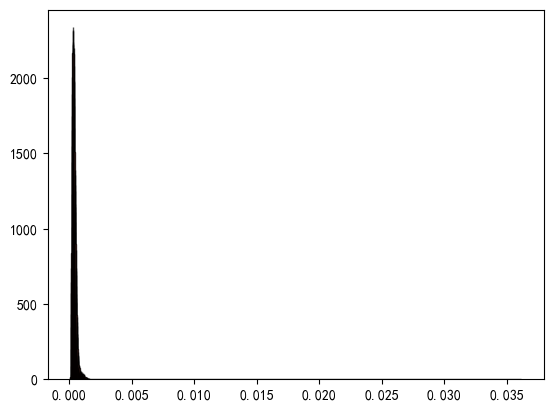

In [73]:
all_losses_numpy = all_losses.numpy() 

plt.hist(all_losses_numpy, bins='auto', color='salmon', edgecolor='black', alpha=0.7)

(array([36., 17., 13.,  8.,  5.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.00238806, 0.00278531, 0.00318255, 0.0035798 , 0.00397704,
        0.00437429, 0.00477154, 0.00516878, 0.00556603, 0.00596327,
        0.00636052, 0.00675776, 0.00715501, 0.00755225, 0.0079495 ,
        0.00834674, 0.00874399, 0.00914123, 0.00953848, 0.00993572,
        0.01033297, 0.01073021, 0.01112746, 0.0115247 , 0.01192195,
        0.01231919, 0.01271644, 0.01311369, 0.01351093, 0.01390818,
        0.01430542, 0.01470267, 0.01509991, 0.01549716, 0.0158944 ,
        0.01629165, 0.01668889, 0.0170861

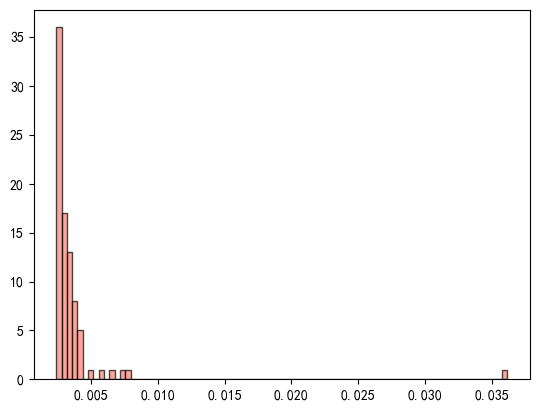

In [74]:
all_losses_numpy = all_losses.numpy() 
reconstruction_errors_of_outliers = all_losses_numpy[outlier_indices]
plt.hist(reconstruction_errors_of_outliers, bins='auto', color='salmon', edgecolor='black', alpha=0.7)

In [75]:
all_losses_numpy = all_losses.numpy() 
reconstruction_errors_of_outliers = all_losses_numpy[outlier_indices]
df_outliers_in_original_table = full4.iloc[outlier_indices]
df_outliers_in_original_table2 = train_dt.iloc[outlier_indices]
errors_for_these_outliers = all_losses_numpy[outlier_indices]
df_outliers_in_original_table['重构误差'] = errors_for_these_outliers
df_outliers_in_original_table2['重构误差'] = errors_for_these_outliers


C:\Windows\Temp\ipykernel_32816\3665156861.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outliers_in_original_table['重构误差'] = errors_for_these_outliers
C:\Windows\Temp\ipykernel_32816\3665156861.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outliers_in_original_table2['重构误差'] = errors_for_these_outliers


In [76]:
df_outliers_in_original_table.to_csv('outliers_summary.csv')
df_outliers_in_original_table2.to_csv('outliers_summary2.csv')

# 第一次：经过分析，引起异常的特征有物业费、燃气费，重构特征处理方式————发现过去错误的特征处理方式
# 第二次：发现两个建筑面积错误的样本

In [77]:
threshold = 0.02
all_reconstructions = autoencoder.predict(data_scaled)
all_losses = tf.keras.losses.mse(all_reconstructions, data_scaled)

outlier_indices = np.where(all_losses > threshold)[0]
normal_indices = np.where(all_losses <= threshold)[0]

2630/2630 ━━━━━━━━━━━━━━━━━━━━ 1s 386us/step


In [78]:
print(f"共删除 {len(outlier_indices)} 个异常值。")
outlier_num=len(outlier_indices)
full5=full3.drop(index=outlier_indices)

共删除 1 个异常值。


# 三、训练模型

# 1.2 初始版本:用对数处理价格

In [79]:
# 使用填补好且编码好的数据：full3

In [80]:
# wenben=pd.read_csv('wenben.csv') 结合统计得到的文本信息无改善

In [69]:
full3.columns

Index(['城市', '区域', '板块_x', '小区名称', '价格', '房屋户型', '所在楼层', '建筑面积', '套内面积',
       '房屋朝向', '建筑结构', '装修情况', '梯户比例', '配备电梯', '别墅类型', '交易时间', '交易权属', '上次交易',
       '房屋用途', '房屋年限', '产权所属', '房屋优势', 'lon', 'lat', '年份', '开发商', '房屋总数',
       '楼栋总数', '物业公司', '绿 化 率', '容 积 率', '物 业 费', '供水', '供电', '燃气费', '供热费',
       '停车位', '环线_填充后', '环线'],
      dtype='object')

          Weight   Gain       Cover
index:      高       中         中
供热费：     低       中        高
挂牌时间：   高       低         高
房屋朝向：   高       低         低

In [66]:
temp=full3.copy()

In [67]:
full3=temp.copy()

In [68]:
# 删除两个自动编码器识别的错误样本

full3=full3.drop(index=82776)
full3=full3.drop(index=57713)

In [69]:
# 结合三个特征重要性表进行特征筛选

full3=full3.drop(columns=['挂牌时间'])
full3=full3.drop(columns=['套内面积'])
full3=full3.drop(columns=['供热费'])
full3=full3.drop(columns=['总房屋'])
# full3['楼栋户数']=full3['户']*full3['总层数']
# full3['厅室比']=full3['户型_厅']/(full3['户型_室']+1)
# full3=full3.drop(columns=['舒适程度'])
# full3=full3.drop(columns=['房屋朝向'])

# full3=full3.drop(columns=['lon'])
# full3=full3.drop(columns=['lat'])
# full3=full3.drop(columns=['供热费'])

# full3['挂牌时间']=full3['挂牌时间']//12

# full3=full3.drop(columns=['产权所属'])
# full3=full3.drop(columns=['年份'])
# full3=full3.drop(columns=['交易月份'])



In [70]:
# 用编码好的数据集训练

outlier_num=2

train2=full3.iloc[:84133-outlier_num]
test2=full3.iloc[84133-outlier_num:]

train2=train2.drop(columns=['小区名称'])
test2=test2.drop(columns=['小区名称'])

In [85]:

y = np.log(train2['价格'])
x= train2.drop(columns=['价格'])
x_fc = test2.drop(columns=['价格'])

x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.1, random_state=422)

dtrain = xgb.DMatrix(x_train, label=y_train,enable_categorical=True)
dtest = xgb.DMatrix(x_test, enable_categorical=True)
dfc = xgb.DMatrix(x_fc, enable_categorical=True)

params = {
    'nthreads': 4, 
    'tree_method':'gpu_hist',
    'objective': 'reg:squarederror',
    'max_depth': 6, 
    
    'eta': 0.05,
    'lambda': 1,
    'alpha': 0,

    'subsample': 0.8, 
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse',
    'seed': 42,

}

model_xgb3 = xgb.train(
    params,
    dtrain,
    num_boost_round=7100 # 迭代次数/树的数量
)
predictions = model_xgb3.predict(dtest)

C:\Users\静默之子\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [21:10:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\静默之子\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [21:10:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "nthreads" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\静默之子\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:729: UserWarning: [21:10:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", d

In [86]:
# 测试组
predictions = np.exp(model_xgb3.predict(dtest))
mae = mean_absolute_error(np.exp(y_test), predictions)
rmse=root_mean_squared_error(np.exp(y_test), predictions)

print("MAE ||RMSE")
print(int(mae), int(rmse))

# 训练组

predictions=np.exp( model_xgb3.predict(dtrain))
mae = mean_absolute_error(np.exp(y_train), predictions)
rmse=root_mean_squared_error(np.exp(y_train), predictions)
print("MAE ||RMSE")
print(int(mae), int(rmse))


MAE ||RMSE
153525 513893
MAE ||RMSE
70713 136715


In [87]:
# 输出预测结果

forecast= np.exp(model_xgb3.predict(dfc))
fc=pd.DataFrame(columns=['ID','价格'])
fc['价格']=forecast
fc['ID']=test['ID']
fc.to_csv('forecast.csv', index=False)

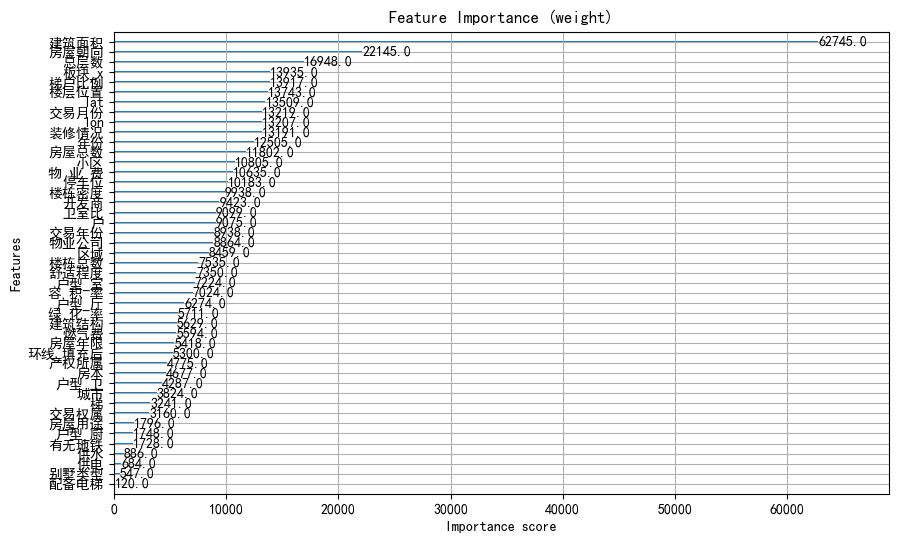

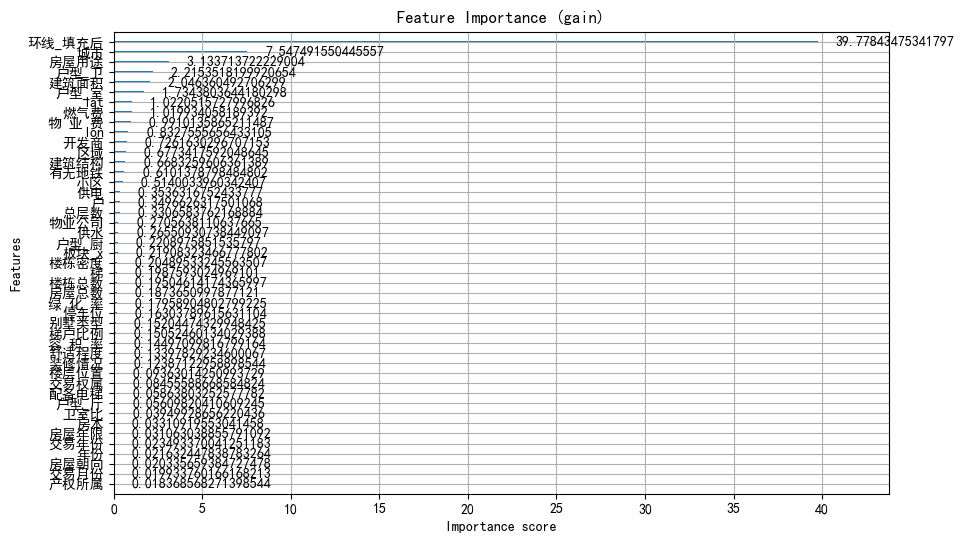

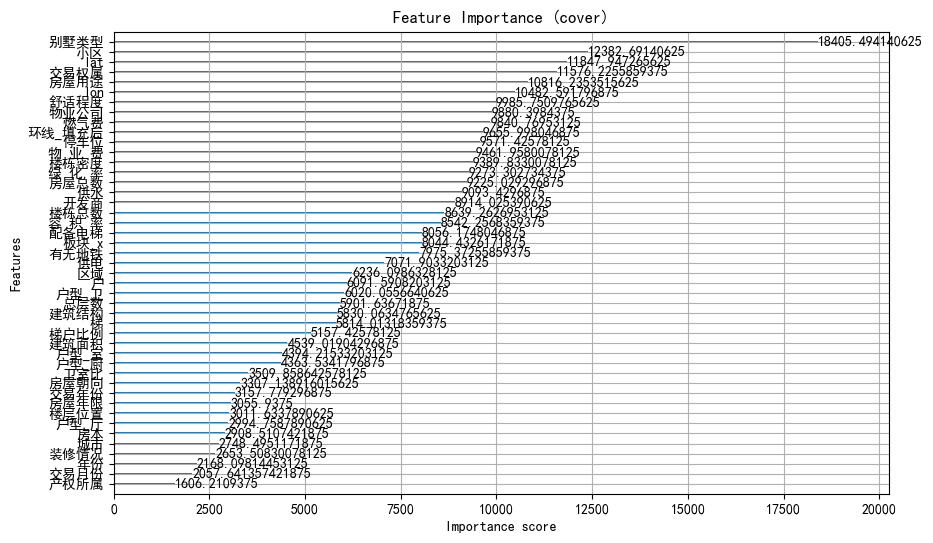

In [88]:
# 画出特征重要性表
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model_xgb3, ax=ax, title='Feature Importance (weight)')
plt.show()

# 2. 绘制基于 'gain' 的特征重要性图
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model_xgb3, ax=ax, importance_type='gain', title='Feature Importance (gain)')
plt.show()

# 3. 绘制基于 'cover' 的特征重要性图
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model_xgb3, ax=ax, importance_type='cover', title='Feature Importance (cover)')
plt.show()

C:\Users\静默之子\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [21:10:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\静默之子\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [21:10:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "nthreads" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


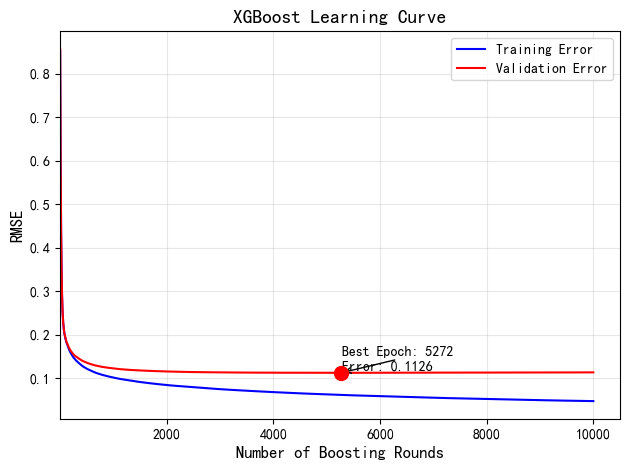

In [89]:
# 画学习曲线寻找最佳树的数目


X_train, X_val, y_train, y_val = train_test_split(
    x, y, test_size=0.1, random_state=422
)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    'nthreads': 4, 
    
    'objective': 'reg:squarederror',
    'max_depth': 6, 
    'tree_method':'gpu_hist',
    'eta': 0.05,
    'lambda': 1,
    'alpha': 0,

    'subsample': 0.8, 
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse',
    'seed': 42,
}

evals_result = {}  # 存储评估结果的字典
num_rounds = 10000

xgb_model = xgb.train(
    params,
    dtrain,
    num_rounds,
    evals=[(dtrain, "train"), (dval, "validation")],  # 设置评估数据集
    evals_result=evals_result,  # 存储评估结果
    verbose_eval=False  # 不在控制台打印每轮结果
)

train_errors = evals_result['train']['rmse']
val_errors = evals_result['validation']['rmse']
epochs = range(1, len(train_errors) + 1)

# 训练误差曲线
plt.plot(epochs, train_errors, 'b-', label='Training Error')
# 验证误差曲线
plt.plot(epochs, val_errors, 'r-', label='Validation Error')

# 标注最小值点
min_val_idx = np.argmin(val_errors)
min_val_epoch = min_val_idx + 1
min_val_error = val_errors[min_val_idx]

plt.scatter(min_val_epoch, min_val_error, c='red', s=100, zorder=5)
plt.annotate(f'Best Epoch: {min_val_epoch}\nError: {min_val_error:.4f}',
             xy=(min_val_epoch, min_val_error),
             xytext=(min_val_epoch+10, min_val_error*1.05),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# 图表美化
plt.title('XGBoost Learning Curve', fontsize=14)
plt.xlabel('Number of Boosting Rounds', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(left=1)
plt.tight_layout()

train_final = train_errors[-1]
val_final = val_errors[-1]
gap = val_final - train_final



plt.show()

# 

# 1.3 用对数单价代替价格（最佳）

In [78]:
outlier_num=2

train2=full3.iloc[:84133-outlier_num]
test2=full3.iloc[84133-outlier_num:]

train2=train2.drop(columns=['小区名称'])
test2=test2.drop(columns=['小区名称'])

y = np.log(train2['价格']/train2['建筑面积'])
x= train2.drop(columns=['价格'])
x_fc = test2.drop(columns=['价格'])

x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.1, random_state=422)

dtrain = xgb.DMatrix(x_train, label=y_train,enable_categorical=True)
dtest = xgb.DMatrix(x_test, enable_categorical=True)
dfc = xgb.DMatrix(x_fc, enable_categorical=True)

params = {
    'nthreads': 4, 
    'tree_method':'gpu_hist',
    'objective': 'reg:squarederror',
    'max_depth': 6, 
    
    'eta': 0.05,
    'lambda': 1,
    'alpha': 0,

    'subsample': 0.8, 
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse',
    'seed': 42,

}

model_xgb4 = xgb.train(
    params,
    dtrain,
    num_boost_round=7100 # 迭代次数/树的数量
)
predictions = model_xgb4.predict(dtest)

C:\Users\静默之子\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [09:37:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\静默之子\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [09:37:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "nthreads" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\静默之子\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:729: UserWarning: [09:38:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", d

In [87]:
# 测试组
predictions = model_xgb4.predict(dtest)
predictions=np.exp(predictions)*x_test['建筑面积']
mae = mean_absolute_error(np.exp(y_test)*x_test['建筑面积'], predictions)
rmse=root_mean_squared_error(np.exp(y_test)*x_test['建筑面积'], predictions)

print("MAE ||RMSE")
print(int(mae), int(rmse))

# 训练组

predictions= np.exp(model_xgb4.predict(dtrain))*x_train['建筑面积']
mae = mean_absolute_error(np.exp(y_train)*x_train['建筑面积'], predictions)
rmse=root_mean_squared_error(np.exp(y_train)*x_train['建筑面积'], predictions)
print("MAE ||RMSE")
print(int(mae), int(rmse))

MAE ||RMSE
143322 419884
MAE ||RMSE
69755 134204


In [ ]:
import optuna
from optuna_integration import XGBoostPruningCallback

def objective(trial, X_train, y_train, X_val, y_val):
    """
    Optuna 目标函数：
    - n_estimators 固定为一个大值。
    - 使用早停策略。
    - Optuna 专注于调整其他超参数。
    """
    # 定义超参数的搜索空间
    # 注意：我们从这里移除了 n_estimators 的搜索！
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 2.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 2.0, log=True),
        'random_state': 42
    }

    # 关键改动：在这里固定一个较大的 n_estimators
    # 我们为模型提供足够的“跑道”，让早停来决定何时“降落”
    model = xgb.XGBRegressor(
        n_estimators=20000,
        early_stopping_rounds=20, # <--- 参数必须放在这里
        callbacks=[XGBoostPruningCallback(trial, "validation_0-rmse")], # <--- 参数必须放在这里
        **params
    )

    # 训练模型，并强制使用早停
    # 早停是这个策略的核心
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)], # 如果验证集 RMSE 连续 50 轮没有改善，则停止
        verbose=True
        # 剪枝回调依然可以和早停一起使用，它能更早地中止不佳的试验
        
    )

    preds = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, preds)

    return rmse

if __name__ == "__main__":
    # 加载和划分数据
    housing = train2
    X, y = housing.drop(columns=['价格']), np.log(housing['价格']/housing['建筑面积'])
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=422)

    # 创建并运行 Study
    study = optuna.create_study(
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5) # 使用剪枝器
    )
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=100)

    # --- 优化结束，输出和使用结果 ---
    print("Optimization finished.")
    print(f"Number of finished trials: {len(study.trials)}")

    print("\nBest trial found:")
    best_trial = study.best_trial
    print(f"  Value (MSE): {best_trial.value:.4f}")
    print(f"  Value (RMSE): {np.sqrt(best_trial.value):.4f}")

    print("\n  Best params found by Optuna: ")
    # 注意这里不会再有 'n_estimators'
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

    # --- 如何使用最佳参数重新训练并找到最佳迭代次数 ---
    print("\nRe-training final model with best params...")
    best_params = best_trial.params
    final_model = xgb.XGBRegressor(n_estimators=20000, **best_params) # 同样使用大数值
    final_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # 获取由早停决定的最佳迭代次数
    best_iteration = final_model.best_iteration
    print(f"\nOptimal number of trees (best_iteration): {best_iteration}")

In [79]:
outlier_num=2

train2=full3.iloc[:84133-outlier_num]
test2=full3.iloc[84133-outlier_num:]

train2=train2.drop(columns=['小区名称'])
test2=test2.drop(columns=['小区名称'])

y = np.log(train2['价格']/train2['建筑面积'])
x= train2.drop(columns=['价格'])
x_fc = test2.drop(columns=['价格'])

x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.1, random_state=422)

dtrain = xgb.DMatrix(x_train, label=y_train,enable_categorical=True)
dtest = xgb.DMatrix(x_test, enable_categorical=True)
dfc = xgb.DMatrix(x_fc, enable_categorical=True)

params = {
    'nthreads': 4, 
    'tree_method':'gpu_hist',
    'objective': 'reg:squarederror',
    'max_depth': 6, 
    
    'eta':  0.03837138862879114,
    'lambda': 3.447023653658107e-07,
    'alpha':  1.3751972807322515e-07,
    'gamma':1.5265331546122063e-05,


    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse',
    'seed': 42,

}

model_xgb4 = xgb.train(
    params,
    dtrain,
    num_boost_round=16000 # 迭代次数/树的数量
)
predictions = model_xgb4.predict(dtest)

C:\Users\静默之子\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [09:39:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\静默之子\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [09:39:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "nthreads" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\静默之子\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:729: UserWarning: [09:40:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", d

In [200]:
# 测试组
predictions = model_xgb4.predict(dtest)
predictions=np.exp(predictions)*x_test['建筑面积']
mae = mean_absolute_error(np.exp(y_test)*x_test['建筑面积'], predictions)
rmse=root_mean_squared_error(np.exp(y_test)*x_test['建筑面积'], predictions)

print("MAE ||RMSE")
print(int(mae), int(rmse))

# 训练组

predictions= np.exp(model_xgb4.predict(dtrain))*x_train['建筑面积']
mae = mean_absolute_error(np.exp(y_train)*x_train['建筑面积'], predictions)
rmse=root_mean_squared_error(np.exp(y_train)*x_train['建筑面积'], predictions)
print("MAE ||RMSE")
print(int(mae), int(rmse))

MAE ||RMSE
142675 413203
MAE ||RMSE
52171 97707


In [196]:
forecast= np.exp(model_xgb4.predict(dfc))*x_fc['建筑面积']
fc=pd.DataFrame(columns=['ID','价格'])
fc['价格']=forecast
fc['ID']=range(0,14786)
fc.to_csv('forecast.csv', index=False)

In [ ]:
'''''
MAE ||RMSE# 最佳
142675 413203
MAE ||RMSE
52171 97707

MAE ||RMSE 
143591 418040
MAE ||RMSE
69863 134886

'''

"''\nMAE ||RMSE# 最佳\n143322 419884\nMAE ||RMSE\n69755 134204\n\nMAE ||RMSE \n143591 418040\nMAE ||RMSE\n69863 134886\n\n"

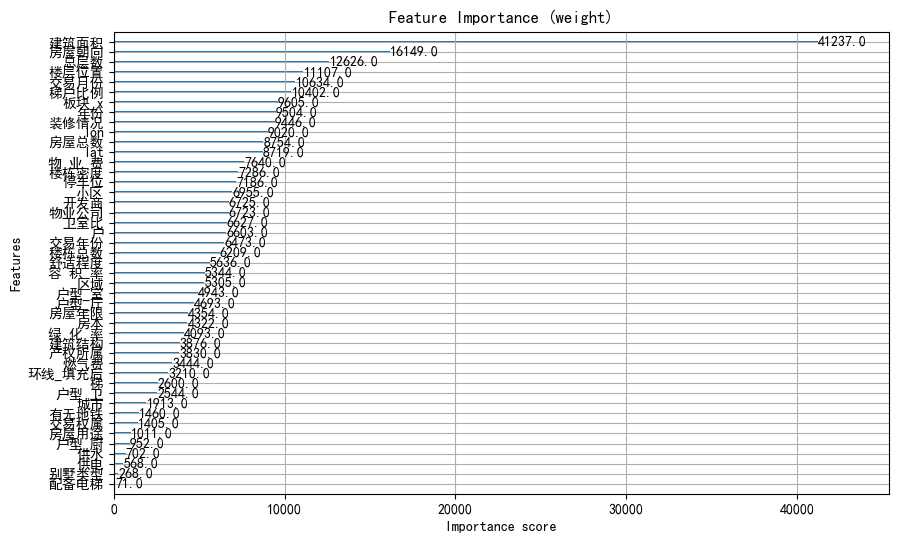

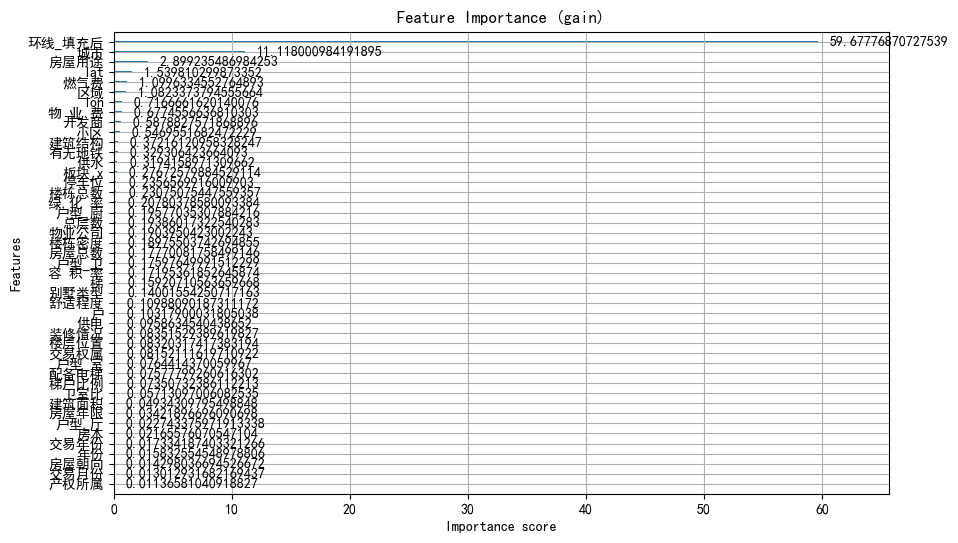

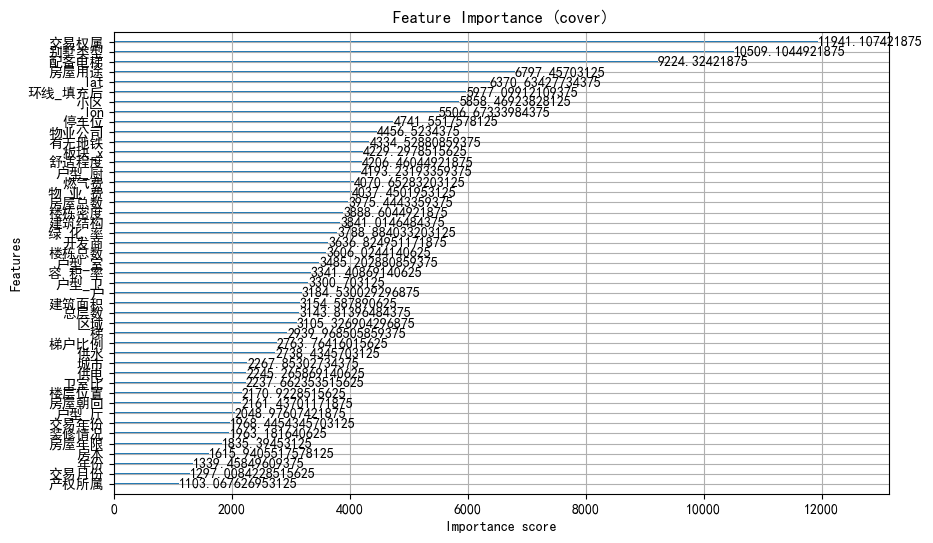

In [155]:
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model_xgb4, ax=ax, title='Feature Importance (weight)')
plt.show()

# 2. 绘制基于 'gain' 的特征重要性图
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model_xgb4, ax=ax, importance_type='gain', title='Feature Importance (gain)')
plt.show()

# 3. 绘制基于 'cover' 的特征重要性图
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model_xgb4, ax=ax, importance_type='cover', title='Feature Importance (cover)')
plt.show()

In [94]:
dpi_setting = 100
width_pixels = 1200
height_pixels = 800

fig_width = width_pixels / dpi_setting
fig_height = height_pixels / dpi_setting
desired_figsize = (fig_width, fig_height)

# --- 2. 生成基于 'weight' 的特征重要性图 ---
fig, ax = plt.subplots(figsize=desired_figsize)
xgb.plot_importance(model_xgb4, ax=ax, title='特征重要性 (weight)')
plt.tight_layout() # 自动调整布局，防止标签被截断
# 使用指定的DPI保存图像
fig.savefig('feature_importance_weight.png', dpi=dpi_setting)
plt.close(fig) # 关闭图像以释放内存

# --- 3. 生成基于 'gain' 的特征重要性图 ---
fig, ax = plt.subplots(figsize=desired_figsize)
xgb.plot_importance(model_xgb4, ax=ax, importance_type='gain', title='特征重要性 (gain)')
plt.tight_layout()
# 保存图像
fig.savefig('feature_importance_gain.png', dpi=dpi_setting)
plt.close(fig)

# --- 4. 生成基于 'cover' 的特征重要性图 ---
fig, ax = plt.subplots(figsize=desired_figsize)
xgb.plot_importance(model_xgb4, ax=ax, importance_type='cover', title='特征重要性 (cover)')
plt.tight_layout()
# 保存图像
fig.savefig('feature_importance_cover.png', dpi=dpi_setting)
plt.close(fig)

print(f"成功生成3张图片，尺寸均为 {width_pixels}x{height_pixels} 像素。")

成功生成3张图片，尺寸均为 1200x800 像素。


In [95]:


importance_gain = model_xgb4.get_score(importance_type='gain')
importance_weight = model_xgb4.get_score(importance_type='weight')
importance_cover = model_xgb4.get_score(importance_type='cover')



sorted_gain = sorted(importance_gain.items(), key=lambda item: item[1], reverse=True)
sorted_weight = sorted(importance_weight.items(), key=lambda item: item[1], reverse=True)
sorted_cover = sorted(importance_cover.items(), key=lambda item: item[1], reverse=True)

ranked_features_gain = [feature for feature, score in sorted_gain]
ranked_features_weight = [feature for feature, score in sorted_weight]
ranked_features_cover = [feature for feature, score in sorted_cover]

leaderboard_df = pd.DataFrame({
    'Gain 指标下的排名': ranked_features_gain,
    'Weight 指标下的排名': ranked_features_weight,
    'Cover 指标下的排名': ranked_features_cover
})

leaderboard_df.index = leaderboard_df.index + 1
# 给索引列命名为 'Rank'
leaderboard_df.index.name = 'Rank'

latex_table_code = leaderboard_df.to_latex()

# 打印生成的代码

print(latex_table_code)
print("---------------------------------")


\begin{tabular}{llll}
\toprule
 & Gain 指标下的排名 & Weight 指标下的排名 & Cover 指标下的排名 \\
Rank &  &  &  \\
\midrule
1 & 环线_填充后 & 建筑面积 & 别墅类型 \\
2 & 城市 & 房屋朝向 & 小区 \\
3 & 房屋用途 & 总层数 & lat \\
4 & lat & 楼层位置 & 交易权属 \\
5 & 燃气费 & 梯户比例 & lon \\
6 & 区域 & 板块_x & 环线_填充后 \\
7 & lon & 交易月份 & 房屋用途 \\
8 & 开发商 & 装修情况 & 舒适程度 \\
9 & 物 业 费 & lon & 停车位 \\
10 & 小区 & lat & 燃气费 \\
11 & 有无地铁 & 年份 & 物业公司 \\
12 & 建筑结构 & 房屋总数 & 楼栋密度 \\
13 & 供水 & 小区 & 绿 化 率 \\
14 & 户型_卫 & 物 业 费 & 房屋总数 \\
15 & 板块_x & 停车位 & 配备电梯 \\
16 & 户型_厨 & 楼栋密度 & 物 业 费 \\
17 & 梯 & 开发商 & 开发商 \\
18 & 房屋总数 & 交易年份 & 容 积 率 \\
19 & 总层数 & 户 & 供水 \\
20 & 物业公司 & 物业公司 & 楼栋总数 \\
21 & 绿 化 率 & 卫室比 & 板块_x \\
22 & 楼栋总数 & 区域 & 有无地铁 \\
23 & 楼栋密度 & 楼栋总数 & 供电 \\
24 & 停车位 & 舒适程度 & 户 \\
25 & 舒适程度 & 容 积 率 & 梯 \\
26 & 容 积 率 & 户型_室 & 建筑结构 \\
27 & 供电 & 户型_厅 & 区域 \\
28 & 户 & 建筑结构 & 总层数 \\
29 & 楼层位置 & 绿 化 率 & 户型_厨 \\
30 & 装修情况 & 燃气费 & 户型_卫 \\
31 & 别墅类型 & 房屋年限 & 梯户比例 \\
32 & 梯户比例 & 房本 & 户型_室 \\
33 & 交易权属 & 产权所属 & 建筑面积 \\
34 & 配备电梯 & 环线_填充后 & 卫室比 \\
35 & 户型_室 & 户型_卫 & 房屋朝向 \\
36 &

(array([2.88198129e-03, 8.07984041e-03, 1.49760099e-02, 2.81507816e-02,
        4.84275785e-02, 8.02323006e-02, 1.48988140e-01, 2.15016390e-01,
        3.26538773e-01, 4.53243022e-01, 5.35585345e-01, 4.97038845e-01,
        4.41663633e-01, 3.31221993e-01, 2.79706577e-01, 2.29940936e-01,
        1.90004910e-01, 1.73073269e-01, 1.17337810e-01, 7.22039242e-02,
        5.23388388e-02, 3.55615906e-02, 2.36734178e-02, 1.19911007e-02,
        6.27860210e-03, 3.29369291e-03, 1.02927903e-03, 8.23423227e-04,
        1.54391855e-04, 2.57319758e-04]),
 array([11.26804742, 11.49900957, 11.72997173, 11.96093388, 12.19189603,
        12.42285818, 12.65382034, 12.88478249, 13.11574464, 13.34670679,
        13.57766895, 13.8086311 , 14.03959325, 14.2705554 , 14.50151756,
        14.73247971, 14.96344186, 15.19440401, 15.42536617, 15.65632832,
        15.88729047, 16.11825262, 16.34921478, 16.58017693, 16.81113908,
        17.04210123, 17.27306339, 17.50402554, 17.73498769, 17.96594984,
        18.19691

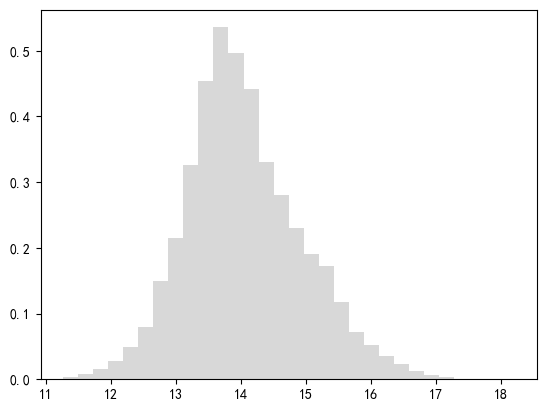

In [97]:
# 对数处理价格后的价格分布

plt.hist(np.log(np.exp(y)*x['建筑面积']), bins=30, density=True, alpha=0.3, color='gray', label='直方图')

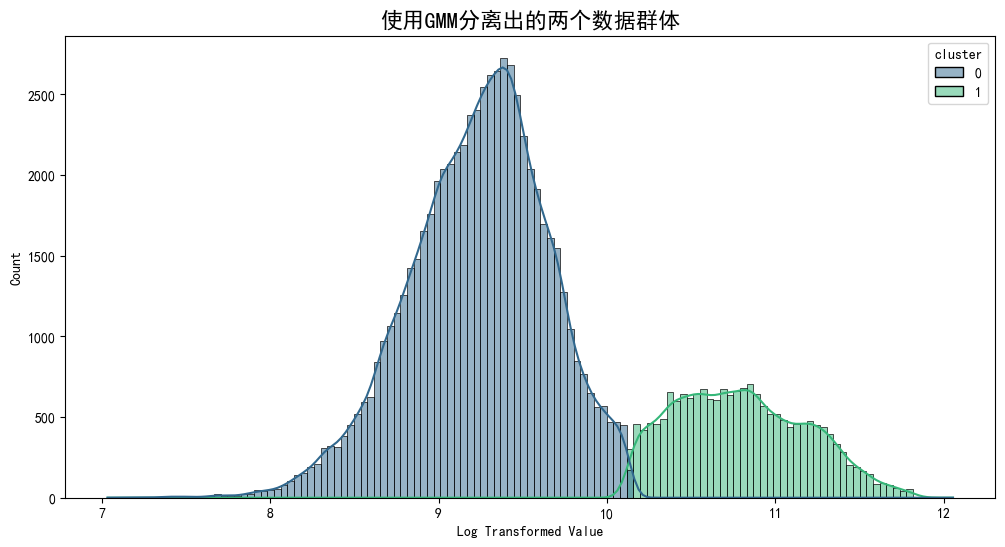

In [98]:
# 对数处理单价后的单价分布

from sklearn.mixture import GaussianMixture

data_bimodal=y
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(data_bimodal.values.reshape(-1, 1))
cluster_labels = gmm.predict(data_bimodal.values.reshape(-1, 1))

df_bimodal = pd.DataFrame({'log_value': data_bimodal, 'cluster': cluster_labels})

plt.figure(figsize=(12, 6))
sns.histplot(data=df_bimodal, x='log_value', hue='cluster', kde=True, palette='viridis')
plt.title('使用GMM分离出的两个数据群体', fontsize=16)
plt.xlabel('Log Transformed Value')
plt.show()

# 2.0 随机森林模型



In [75]:
train3=full3.iloc[:84133-outlier_num]
test3=full3.iloc[84133-outlier_num:]

train3=train3.drop(columns=['小区名称'])
test3=test3.drop(columns=['小区名称'])

y = np.log(train3['价格']/train3['建筑面积'])
x= train3.drop(columns=['价格'])
x_fc = test3.drop(columns=['价格'])

x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.1, random_state=422)

In [187]:
# 使用随机森林模型

rf_model = RandomForestRegressor(n_estimators=200, random_state=42,min_samples_leaf=1,oob_score=True,max_features=0.6)
rf_model.fit(x_train, y_train)





RandomForestRegressor(max_features=0.6, n_estimators=200, oob_score=True,
                      random_state=42)

In [ ]:
import optuna
from optuna_integration import XGBoostPruningCallback

housing = train2
X, y = housing.drop(columns=['价格']), np.log(housing['价格']/housing['建筑面积'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=422)

def objective(trial, X_train, y_train, X_val, y_val):
    """
    Optuna 目标函数 (针对 RandomForestRegressor):
    - Optuna 专注于调整 RandomForest 的核心超参数。
    """
    # 1. 定义 RandomForest 的超参数搜索空间
    #    注意：n_estimators 在这里是直接优化的目标
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=50),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'random_state': 42,
        'n_jobs': -1  # 使用所有可用的 CPU核心
    }

    # 2. 创建 RandomForest 模型
    #    不再有 early_stopping_rounds 或 callbacks
    model = RandomForestRegressor(**params)

    # 3. 训练模型
    #    fit 方法更简单，不需要 eval_set
    model.fit(X_train, y_train)

    # 4. 预测并计算评估指标 (RMSE)
    preds = model.predict(X_val)
    # 使用 mean_squared_error 并取平方根
    rmse = root_mean_squared_error(y_val, preds)

    return rmse

if __name__ == "__main__":
    # 创建并运行 Study
    # Pruner (剪枝器) 仍然可以使用，它会比较不同试验的最终结果
    study = optuna.create_study(
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
    )
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=100)

    # --- 优化结束，输出和使用结果 ---
    print("\nOptimization finished.")
    print(f"Number of finished trials: {len(study.trials)}")

    print("\nBest trial found:")
    best_trial = study.best_trial
    # 目标函数直接返回 RMSE，所以 best_trial.value 就是最佳 RMSE
    print(f"  Value (RMSE): {best_trial.value:.4f}")

    print("\n  Best params found by Optuna: ")
    # 对于随机森林, 'n_estimators' 是直接被优化的关键参数之一
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

    # --- 如何使用最佳参数重新训练最终模型 ---
    print("\nRe-training final model with best params...")
    best_params = best_trial.params
    
    # 直接使用 Optuna 找到的所有最佳参数 (包括 n_estimators) 来创建最终模型
    final_model = RandomForestRegressor(**best_params)
    
    # 通常在找到最佳参数后，会使用所有训练数据来训练最终模型
    # 也可以选择使用整个数据集 (X, y) 进行训练
    final_model.fit(X_train, y_train)

    print("\nFinal model has been trained with the best hyperparameters.")
    # 对于随机森林，没有 "best_iteration" 的概念
    # 模型已经用最佳的 n_estimators 参数构建好了
    print(f"The model was trained with n_estimators = {best_params['n_estimators']}.")


In [76]:
# 使用随机森林模型

rf_model = RandomForestRegressor(n_estimators=500, random_state=42,min_samples_split=4,oob_score=True,max_features=0.6,max_depth=29)
rf_model.fit(x_train, y_train)





RandomForestRegressor(max_depth=29, max_features=0.6, min_samples_split=4,
                      n_estimators=500, oob_score=True, random_state=42)

In [77]:
# 随机森林模型

# 测试组
rf_predictions = np.exp(rf_model.predict(x_test))*x_test['建筑面积']
mae = mean_absolute_error(np.exp(y_test)*x_test['建筑面积'], rf_predictions)
rmse=root_mean_squared_error(np.exp(y_test)*x_test['建筑面积'], rf_predictions)

print("MAE ||RMSE")
print(int(mae), int(rmse))

# 训练组

rf_predictions= np.exp(rf_model.predict(x_train))*x_train['建筑面积']
mae = mean_absolute_error(np.exp(y_train)*x_train['建筑面积'], rf_predictions)
rmse=root_mean_squared_error(np.exp(y_train)*x_train['建筑面积'], rf_predictions)
print("MAE ||RMSE")
print(int(mae), int(rmse))


MAE ||RMSE
142984 443593
MAE ||RMSE
67353 198939


In [ ]:
'''
MAE ||RMSE# 最佳XGboost
143322 419884
MAE ||RMSE
69755 134204

0.7

MAE ||RMSE
143392 441376
MAE ||RMSE
53299 166259

0.6

MAE ||RMSE
142941 442176
MAE ||RMSE
53375 167862

MAE ||RMSE optuna
142984 443593
MAE ||RMSE
67353 198939

'''

In [169]:
forecast= np.exp(rf_model.predict(x_fc))*x_fc['建筑面积']
fc=pd.DataFrame(columns=['ID','价格'])
fc['价格']=forecast
fc['ID']=range(0,14786)
fc.to_csv('forecast_rf.csv', index=False)

# 残差分析

In [218]:
# 价格

dx=xgb.DMatrix(x)
y_pred_xgb2=model_xgb3.predict(dx)
residual2=np.exp(y)*x['建筑面积']-np.exp(y_pred_xgb2)

In [80]:
# 单价

dx=xgb.DMatrix(x)
y_pred_xgb=model_xgb4.predict(dx)
residual=np.exp(y)*x['建筑面积']-np.exp(y_pred_xgb)*x['建筑面积']

In [81]:
y_pred_rf=rf_model.predict(x)
residual_rf=np.exp(y)*x['建筑面积']-np.exp(y_pred_rf)*x['建筑面积']

In [ ]:
cor=np.corrcoef(residual,residual2)
cor

In [82]:
cor=np.corrcoef(residual,residual_rf)
cor

array([[1.        , 0.65455808],
       [0.65455808, 1.        ]])

In [223]:
cor=np.corrcoef(residual2,residual_rf)
cor

array([[1.        , 0.54659179],
       [0.54659179, 1.        ]])

In [224]:
np.median(residual_rf)

-732.9967008270323

In [226]:
np.median(residual)

-919.7148144528037

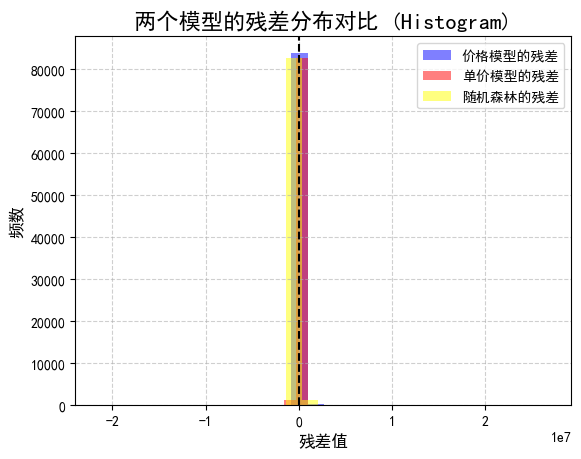

In [227]:
plt.hist(residual2, bins=20, alpha=0.5, label='价格模型的残差', color='blue')
plt.hist(residual, bins=20, alpha=0.5, label='单价模型的残差', color='red')
plt.hist(residual_rf, bins=20, alpha=0.5, label='随机森林的残差', color='yellow')
# 添加一条表示零误差的垂直线
plt.axvline(0, color='black', linestyle='--', linewidth=1.5)

plt.title('两个模型的残差分布对比 (Histogram)', fontsize=16)
plt.xlabel('残差值', fontsize=12)
plt.ylabel('频数', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

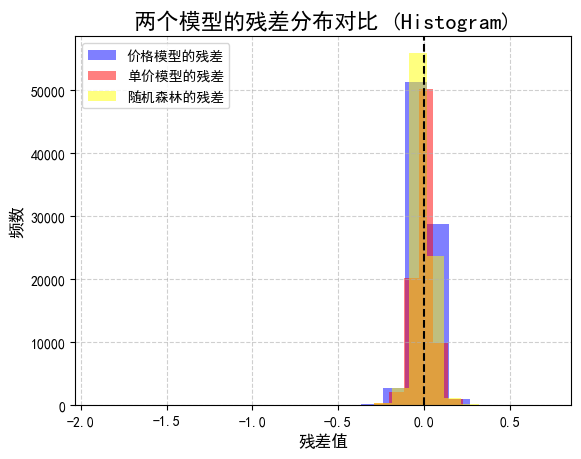

In [228]:
# 百分比残差

plt.hist(residual2/(np.exp(y)*x['建筑面积']), bins=20, alpha=0.5, label='价格模型的残差', color='blue')
plt.hist(residual/(np.exp(y)*x['建筑面积']), bins=20, alpha=0.5, label='单价模型的残差', color='red')
plt.hist(residual_rf/(np.exp(y)*x['建筑面积']), bins=20, alpha=0.5, label='随机森林的残差', color='yellow')

# 添加一条表示零误差的垂直线
plt.axvline(0, color='black', linestyle='--', linewidth=1.5)

plt.title('两个模型的残差分布对比 (Histogram)', fontsize=16)
plt.xlabel('残差值', fontsize=12)
plt.ylabel('频数', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 3.0 集成模型

In [83]:
# 使用加权平均集成xgboost模型和随机森林


alpha=0.8
beta=0.2

In [84]:
# 测试组


predictions = model_xgb4.predict(dtest)
predictions=np.exp(predictions)*x_test['建筑面积']*alpha+np.exp(rf_model.predict(x_test))*x_test['建筑面积']*beta
mae = mean_absolute_error(np.exp(y_test)*x_test['建筑面积'], predictions)
rmse=root_mean_squared_error(np.exp(y_test)*x_test['建筑面积'], predictions)

print("MAE ||RMSE")
print(int(mae), int(rmse))

# 训练组

predictions= np.exp(model_xgb4.predict(dtrain))*x_train['建筑面积']*alpha+np.exp(rf_model.predict(x_train))*x_train['建筑面积']*beta
mae = mean_absolute_error(np.exp(y_train)*x_train['建筑面积'], predictions)
rmse=root_mean_squared_error(np.exp(y_train)*x_train['建筑面积'], predictions)
print("MAE ||RMSE")
print(int(mae), int(rmse))

MAE ||RMSE
139900 408606
MAE ||RMSE
53652 104540


In [ ]:
'''''
1

MAE ||RMSE
142675 413203
MAE ||RMSE
52171 97707

0.5
MAE ||RMSE
138212 412585
MAE ||RMSE
59385 133296

0.8 # 最佳
MAE ||RMSE
139815 406838
MAE ||RMSE
51031 98868

0.75
MAE ||RMSE
139418 411514
MAE ||RMSE
64016 128676

0.4
MAE ||RMSE
138317 415663
MAE ||RMSE
57807 137831


'''

"''\n1\n\nMAE ||RMSE\n143322 419884\nMAE ||RMSE\n69755 134204\n\n0.5\nMAE ||RMSE\n138212 412585\nMAE ||RMSE\n59385 133296\n\n0.8 # 最佳\nMAE ||RMSE\n140002 412442\nMAE ||RMSE\n65059 128978\n\n0.75\nMAE ||RMSE\n139418 411514\nMAE ||RMSE\n64016 128676\n\n0.4\nMAE ||RMSE\n138317 415663\nMAE ||RMSE\n57807 137831\n\n\n"

In [212]:
forecast= np.exp(model_xgb4.predict(dfc))*x_fc['建筑面积']*alpha+np.exp(rf_model.predict(x_fc))*x_fc['建筑面积']*beta
fc=pd.DataFrame(columns=['ID','价格'])
fc['价格']=forecast
fc['ID']=range(0,14786)
fc.to_csv('forecast.csv', index=False)

# 总结

最终使用到的特征：请看1.3特征重要性表




| 指标      | Hackthon 分数| 测试集MAE  | 测试集RMSE | 训练集MAE  | 训练集RMSE |异常值| 测试集的总数 N                | 



|Xgboost    |85.124        | 143322 | 419884 |69755 |134204 |  2 |  测试集使用10%的总样本    |

|随机森林 | 84.292 | 142941 | 442176 |  53375 |167862 | 2 |测试集使用10%的总样本    |

In [153]:
def pdp(model, df, feature:str,cat=False, step=10,winsor=0.02 ):
    import matplotlib.pyplot as plt
    if cat:
        grid = pd.DataFrame(df[feature].unique()).sort_values(0)[0]
    else:
        grid = np.linspace(df[feature].quantile(winsor),df[feature].quantile(1-winsor),step)
    prediction=[]
    print(f'cal {feature},step: ',end='')
    i = 0
    for value in grid:
        i+=1
        print(f'{i}',end=' ')
        X = df.copy()
        X[feature] = value
        preds = np.exp(model.predict(xgb.DMatrix(X,enable_categorical=True)))*df['建筑面积']
        prediction.append(preds.mean())
    plt.plot(grid,prediction)
    plt.xlabel(f'{feature}')
    plt.show()
    return prediction

In [103]:
full3.columns

Index(['城市', '区域', '板块_x', '价格', '建筑面积', '房屋朝向', '建筑结构', '装修情况', '梯户比例',
       '配备电梯', '别墅类型', '交易权属', '房屋用途', '房屋年限', '产权所属', 'lon', 'lat', '年份',
       '开发商', '房屋总数', '楼栋总数', '物业公司', '绿 化 率', '容 积 率', '物 业 费', '供水', '供电',
       '燃气费', '停车位', '环线_填充后', '交易年份', '交易月份', '户型_室', '户型_厅', '户型_厨', '户型_卫',
       '卫室比', '楼层位置', '总层数', '梯', '户', '有无地铁', '房本', '楼栋密度', '舒适程度', '小区'],
      dtype='object')

In [96]:
full3=full3.drop(columns=['小区名称'])

cal 梯户比例,step: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

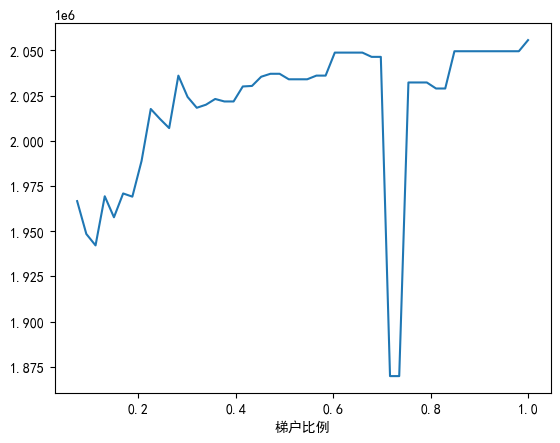

In [164]:
pre=pdp(model=model_xgb4,feature='梯户比例',df=full3.drop(columns=['价格']),step=50,winsor=0.02,cat=False)

cal 梯户比例,step: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

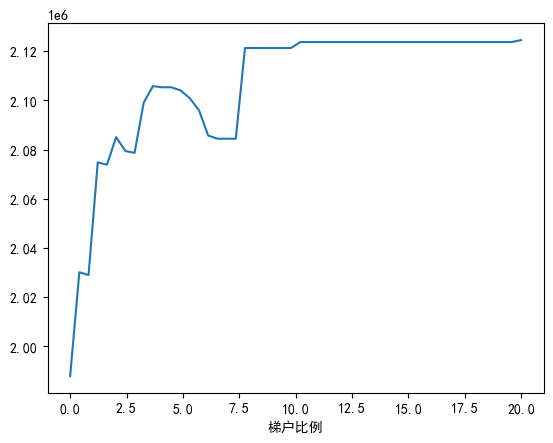

In [165]:
pre=pdp(model=model_xgb4,feature='梯户比例',df=full3.drop(columns=['价格']),step=50,winsor=0,cat=False)